In [1]:
# Install required packages
!pip install earthengine-api
!pip install geemap
!pip install folium
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.3 MB/s eta 0:00:00


In [2]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
project_id = 'ee-cuneerajjaiswal'
# Initialize Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project = project_id)

In [3]:
# Create a new map to draw area of interest
Map = geemap.Map()
Map.add_basemap('SATELLITE')

# Add drawing tools to the map
Map.draw_features

print("Instructions:")
print("1. Use the drawing tools in the upper left corner of the map")
print("2. Click the polygon tool (rectangle or polygon)")
print("3. Draw your area of interest")
print("4. After drawing, the coordinates will be stored")

Map

Instructions:
1. Use the drawing tools in the upper left corner of the map
2. Click the polygon tool (rectangle or polygon)
3. Draw your area of interest
4. After drawing, the coordinates will be stored


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [4]:
# Get the last drawn feature and convert to ROI
aoi = Map.draw_last_feature
if aoi:
    print("Area of interest successfully captured!")
    # Convert to Earth Engine geometry
    roi = ee.Geometry(aoi.geometry())
    print("ROI successfully created!")
else:
    print("Please draw an area first!")

Area of interest successfully captured!
ROI successfully created!


In [5]:
# Define time period
start_date = '2023-01-01'
end_date = '2023-12-31'

# Get Sentinel-2 imagery
s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                .filterBounds(roi)
                .filterDate(start_date, end_date)
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

# Print number of images
print(f"Number of images found: {s2_collection.size().getInfo()}")

# Get the first image
first_image = ee.Image(s2_collection.first())

# Create visualization parameters
vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000
}

# Create new map
new_map = geemap.Map()

# Add layers
new_map.centerObject(roi, 10)
new_map.addLayer(first_image, vis_params, 'Sentinel-2 Image')
new_map.addLayer(roi, {'color': 'red'}, 'Study Area')

# Display map
new_map

Number of images found: 75


Map(center=[30.893262695147943, 75.95443150000177], controls=(WidgetControl(options=['position', 'transparent_…

In [6]:
# Function to calculate NDVI
def calculate_ndvi(image):
    # Select NIR (B8) and RED (B4) bands
    nir = image.select('B8')
    red = image.select('B4')

    # Calculate NDVI
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

    return ndvi

# Get a cloud-free image composite
composite = s2_collection.median().clip(roi)

# Calculate NDVI
ndvi = calculate_ndvi(composite)

# Set visualization parameters for NDVI
ndvi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['#ff0000', '#ffff00', '#00ff00']  # Red to Yellow to Green
}

# Create a new map for NDVI visualization
ndvi_map = geemap.Map()
ndvi_map.centerObject(roi, 10)

# Add NDVI layer
ndvi_map.addLayer(ndvi.clip(roi), ndvi_viz, 'NDVI')

# Add legend with correct format
legend_keys = ['Poor Vegetation (-1 to 0)', 'Moderate Vegetation (0 to 0.5)', 'Healthy Vegetation (0.5 to 1)']
legend_colors = ['#ff0000', '#ffff00', '#00ff00']

ndvi_map.add_legend(
    title='NDVI Values',
    colors=legend_colors,
    keys=legend_keys
)

# Display the map
ndvi_map

Map(center=[30.893262695147943, 75.95443150000177], controls=(WidgetControl(options=['position', 'transparent_…

In [7]:
# Calculate NDVI statistics for the region
stats = ndvi.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ).combine(
        reducer2=ee.Reducer.minMax(),
        sharedInputs=True
    ),
    geometry=roi,
    scale=10,
    maxPixels=2e9
)

# Print statistics
print("\nNDVI Statistics for your region:")
print(f"Mean NDVI: {stats.get('NDVI_mean').getInfo():.3f}")
print(f"Standard Deviation: {stats.get('NDVI_stdDev').getInfo():.3f}")
print(f"Minimum NDVI: {stats.get('NDVI_min').getInfo():.3f}")
print(f"Maximum NDVI: {stats.get('NDVI_max').getInfo():.3f}")


NDVI Statistics for your region:
Mean NDVI: 0.204
Standard Deviation: 0.109
Minimum NDVI: -0.048
Maximum NDVI: 0.546


In [28]:
# Define export task
export_task = ee.batch.Export.image.toDrive(
    image=ndvi,
    description='NDVI_Export',
    folder='NDVI_Data',  # Change to your Google Drive folder
    fileNamePrefix='NDVI_Map',
    region=roi,
    scale=10,
    maxPixels=2e9
)

# Start export task
export_task.start()
print("Exporting NDVI as GeoTIFF... Check Google Drive for the file.")


Exporting NDVI as GeoTIFF... Check Google Drive for the file.


In [30]:
# Reduce NDVI values to a CSV format
ndvi_stats = ndvi.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=roi,
    scale=10,
    maxPixels=2e9
)

# Convert to Pandas DataFrame
ndvi_values = ndvi_stats.get('NDVI').getInfo()
ndvi_df = pd.DataFrame({'NDVI': ndvi_values})

# Save as CSV
ndvi_df.to_csv('ndvi_values.csv', index=False)
print("NDVI values saved as CSV. Download it from Google Colab Files.")


NDVI values saved as CSV. Download it from Google Colab Files.


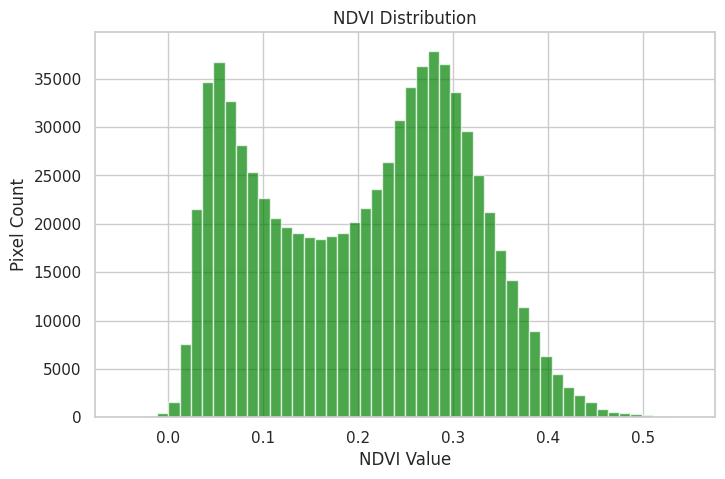

In [31]:
plt.figure(figsize=(8, 5))
plt.hist(ndvi_values, bins=50, color='green', alpha=0.7)
plt.xlabel('NDVI Value')
plt.ylabel('Pixel Count')
plt.title('NDVI Distribution')
plt.show()


In [32]:
# Dictionary to handle month-end dates correctly
month_end_days = {
    1: 31,  2: 28,  3: 31,  4: 30,  5: 31,  6: 30,
    7: 31,  8: 31,  9: 30, 10: 31, 11: 30, 12: 31
}

# Function to calculate NDVI for each month
def get_monthly_ndvi(year, month):
    start_date = f'{year}-{month:02d}-01'
    end_date = f'{year}-{month:02d}-{month_end_days[month]}'

    monthly_collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                          .filterBounds(roi)
                          .filterDate(start_date, end_date)
                          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

    # Get median image for the month
    monthly_composite = monthly_collection.median()

    # Calculate NDVI
    ndvi = calculate_ndvi(monthly_composite)

    return ndvi

# Generate NDVI for each month in 2023
monthly_ndvi_images = {}
for month in range(1, 13):
    monthly_ndvi_images[month] = get_monthly_ndvi(2023, month)

print("Monthly NDVI images generated successfully!")


Monthly NDVI images generated successfully!


In [33]:
# Define seasonal ranges (adjust based on the region)
seasons = {
    'Winter': [12, 1, 2],
    'Summer': [3, 4, 5],
    'Monsoon': [6, 7, 8],
    'Post-Monsoon': [9, 10, 11]
}

# Compute NDVI for each season
seasonal_ndvi = {}
for season, months in seasons.items():
    season_collection = ee.ImageCollection([
        monthly_ndvi_images[month] for month in months
    ])

    # Take the median NDVI for the season
    seasonal_ndvi[season] = season_collection.median()

print("Seasonal NDVI images generated successfully!")


Seasonal NDVI images generated successfully!


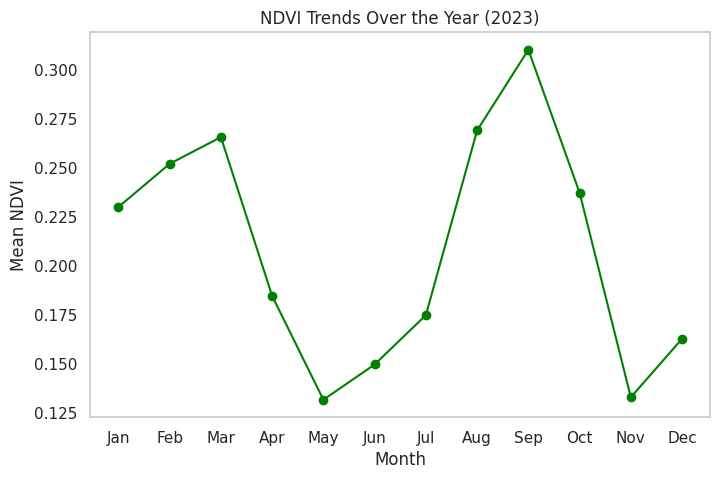

In [34]:
# Extract mean NDVI values for each month
monthly_means = []
for month in range(1, 13):
    stats = monthly_ndvi_images[month].reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=10,
        maxPixels=2e9
    )
    monthly_means.append(stats.get('NDVI').getInfo())

# Plot NDVI trends
plt.figure(figsize=(8, 5))
plt.plot(range(1, 13), monthly_means, marker='o', color='green', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Mean NDVI')
plt.title('NDVI Trends Over the Year (2023)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()


In [35]:
for season, ndvi_image in seasonal_ndvi.items():
    task = ee.batch.Export.image.toDrive(
        image=ndvi_image,
        description=f'NDVI_{season}',
        folder='NDVI_Seasons',
        fileNamePrefix=f'NDVI_{season}',
        region=roi,
        scale=10,
        maxPixels=2e9
    )
    task.start()
    print(f"Exporting {season} NDVI map to Google Drive...")


Exporting Winter NDVI map to Google Drive...
Exporting Summer NDVI map to Google Drive...
Exporting Monsoon NDVI map to Google Drive...
Exporting Post-Monsoon NDVI map to Google Drive...


In [8]:
pip install openmeteo_requests requests_cache retry_requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.8 MB/s eta 0:00:00


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry
from datetime import datetime
import ee
import seaborn as sns

# Extract coordinates from the user-selected area (ROI)
roi_bounds = roi.bounds().getInfo()['coordinates'][0]
# Calculate the center and bounds of the bounding box
lon_min = min(point[0] for point in roi_bounds)
lon_max = max(point[0] for point in roi_bounds)
lat_min = min(point[1] for point in roi_bounds)
lat_max = max(point[1] for point in roi_bounds)

# Calculate centroid for climate data
longitude = (lon_min + lon_max) / 2
latitude = (lat_min + lat_max) / 2

print(f"Processing area with bounds: Lat [{lat_min:.4f}, {lat_max:.4f}], Lon [{lon_min:.4f}, {lon_max:.4f}]")
print(f"Using centroid for climate data: {latitude:.4f}°N, {longitude:.4f}°E")

# --------------------------------------------------
# Part 2: Extract NDVI data using Earth Engine
# --------------------------------------------------

# Define the time range
start_year = 2019
end_year = 2024

# Function to calculate weekly NDVI statistics
def get_weekly_ndvi_stats(start_date, end_date):
    # Get Sentinel-2 collection
    collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                 .filterBounds(roi)
                 .filterDate(start_date, end_date)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

    # Skip if no images available
    if collection.size().getInfo() == 0:
        print(f"  No images available for {start_date} to {end_date}")
        return {
            'date': start_date,
            'ndvi_mean': None,
            'ndvi_std': None,
            'ndvi_min': None,
            'ndvi_max': None
        }

    # Function to calculate NDVI for Sentinel-2
    def calc_ndvi(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return image.addBands(ndvi)

    # Map the NDVI calculation over the collection
    ndvi_collection = collection.map(calc_ndvi)

    # Create weekly composite (median)
    weekly_composite = ndvi_collection.select('NDVI').median()

    # Calculate statistics
    stats = weekly_composite.reduceRegion(
        reducer=ee.Reducer.mean().combine(
            reducer2=ee.Reducer.stdDev(),
            sharedInputs=True
        ).combine(
            reducer2=ee.Reducer.minMax(),
            sharedInputs=True
        ),
        geometry=roi,
        scale=10,  # 10m resolution for Sentinel-2
        maxPixels=1e9
    )

    # Return statistics as dictionary
    return {
        'date': start_date,
        'ndvi_mean': stats.get('NDVI_mean').getInfo(),
        'ndvi_std': stats.get('NDVI_stdDev').getInfo(),
        'ndvi_min': stats.get('NDVI_min').getInfo(),
        'ndvi_max': stats.get('NDVI_max').getInfo()
    }

# Generate weekly dates from 2018-01-01 to current date
current_date = datetime.now().strftime("%Y-%m-%d")
date_range = pd.date_range(start='2019-01-01', end=current_date, freq='W-MON')
dates = [date.strftime("%Y-%m-%d") for date in date_range]

# Calculate NDVI statistics for each week
print("Calculating weekly NDVI data (2019-2024) for the selected area...")
weekly_ndvi = []

for i in range(len(dates) - 1):
    start_date = dates[i]
    end_date = dates[i+1]
    print(f"Processing week {start_date} to {end_date}...")
    try:
        week_stats = get_weekly_ndvi_stats(start_date, end_date)
        weekly_ndvi.append(week_stats)
        print(f"  Week processed successfully.")
    except Exception as e:
        print(f"  Error processing week {start_date} to {end_date}: {str(e)}")
        # Add empty record to maintain continuity
        weekly_ndvi.append({
            'date': start_date,
            'ndvi_mean': None,
            'ndvi_std': None,
            'ndvi_min': None,
            'ndvi_max': None
        })

# Convert to DataFrame
ndvi_df = pd.DataFrame(weekly_ndvi)
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])

# --------------------------------------------------
# Part 3: Get climate data from Open-Meteo for the same area
# --------------------------------------------------

print(f"Getting climate data for coordinates: {latitude:.4f}°N, {longitude:.4f}°E")

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Set date range from 2019 to current date
start_date = "2019-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

# Make sure all required weather variables are listed here
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date,
    "end_date": end_date,
    "daily": [
        "temperature_2m_max",
        "temperature_2m_min",
        "temperature_2m_mean",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "precipitation_hours",
        "soil_temperature_0_to_7cm_mean",
        "soil_moisture_0_to_7cm_mean"
    ],
    "timezone": "auto"
}

print("Fetching climate data from Open-Meteo...")
responses = openmeteo.weather_api(url, params=params)

# Process first location
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m above sea level")
print(f"Timezone: {response.Timezone()} ({response.TimezoneAbbreviation()})")

# Process daily data
daily = response.Daily()
daily_temp_max = daily.Variables(0).ValuesAsNumpy()
daily_temp_min = daily.Variables(1).ValuesAsNumpy()
daily_temp_mean = daily.Variables(2).ValuesAsNumpy()
daily_precip_sum = daily.Variables(3).ValuesAsNumpy()
daily_rain_sum = daily.Variables(4).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(5).ValuesAsNumpy()
daily_precip_hours = daily.Variables(6).ValuesAsNumpy()
daily_soil_temp = daily.Variables(7).ValuesAsNumpy()
daily_soil_moisture = daily.Variables(8).ValuesAsNumpy()

# Create DataFrame with daily data
daily_data = {"date": pd.date_range(
    start=pd.to_datetime(daily.Time(), unit="s"),
    end=pd.to_datetime(daily.TimeEnd(), unit="s"),
    freq=pd.Timedelta(seconds=daily.Interval()),
    inclusive="left"
)}

daily_data["temperature_2m_max"] = daily_temp_max
daily_data["temperature_2m_min"] = daily_temp_min
daily_data["temperature_2m_mean"] = daily_temp_mean
daily_data["precipitation_sum"] = daily_precip_sum
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum
daily_data["precipitation_hours"] = daily_precip_hours
daily_data["soil_temperature_0_to_7cm_mean"] = daily_soil_temp
daily_data["soil_moisture_0_to_7cm_mean"] = daily_soil_moisture

# Create DataFrame
climate_df = pd.DataFrame(data=daily_data)

# --------------------------------------------------
# Part 4: Aggregate climate data to weekly
# --------------------------------------------------

# Convert date to datetime
climate_df['date'] = pd.to_datetime(climate_df['date'])

# Set the date as index for resampling
climate_df = climate_df.set_index('date')

# Resample to weekly data (Monday to Sunday)
weekly_climate = climate_df.resample('W-MON').agg({
    'temperature_2m_max': 'max',
    'temperature_2m_min': 'min',
    'temperature_2m_mean': 'mean',
    'precipitation_sum': 'sum',
    'rain_sum': 'sum',
    'snowfall_sum': 'sum',
    'precipitation_hours': 'sum',
    'soil_temperature_0_to_7cm_mean': 'mean',
    'soil_moisture_0_to_7cm_mean': 'mean'
})

# Reset index to get date as a column again
weekly_climate = weekly_climate.reset_index()

# --------------------------------------------------
# Part 5: Merge NDVI and Climate data
# --------------------------------------------------

# Merge datasets
merged_df = pd.merge(ndvi_df, weekly_climate, on='date', how='left')

# --------------------------------------------------
# Part 6: Add seasonal and derived features
# --------------------------------------------------

# Add time-based features
merged_df['year'] = merged_df['date'].dt.year
merged_df['month'] = merged_df['date'].dt.month
merged_df['day_of_year'] = merged_df['date'].dt.dayofyear
merged_df['week_of_year'] = merged_df['date'].dt.isocalendar().week

# Define seasons (adjusted for your specified seasons)
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

merged_df['season'] = merged_df['month'].apply(get_season)

# Add rolling statistics (4 weeks ≈ 30 days)
# Set 'date' as index temporarily for easier rolling calculations
merged_df = merged_df.set_index('date')
merged_df['ndvi_min_30day'] = merged_df['ndvi_mean'].rolling(window=4, min_periods=1).min()
merged_df['ndvi_max_30day'] = merged_df['ndvi_mean'].rolling(window=4, min_periods=1).max()
merged_df['ndvi_rolling_std'] = merged_df['ndvi_mean'].rolling(window=4, min_periods=1).std().fillna(0)
merged_df = merged_df.reset_index()  # Reset index back

# Add year-over-year patterns
merged_df['ndvi_same_week_last_year'] = merged_df.groupby(['week_of_year'])['ndvi_mean'].shift(52)

# Create seasonal average (excluding current year)
merged_df['ndvi_seasonal_avg'] = merged_df.groupby(['week_of_year'])['ndvi_mean'].transform(
    lambda x: x.expanding().mean()
)

# Fill NaN values in seasonal features
# For the first occurrence, use the current NDVI value
merged_df = merged_df.fillna({
    'ndvi_same_week_last_year': merged_df['ndvi_mean'],
    'ndvi_seasonal_avg': merged_df['ndvi_mean']
})

# Fill any remaining NaNs with forward fill then backward fill
merged_df = merged_df.fillna(method='ffill').fillna(method='bfill')

# --------------------------------------------------
# Part 7: Save the final dataset with area identifier
# --------------------------------------------------

# Generate area identifier from coordinates
area_id = f"area_{latitude:.2f}N_{longitude:.2f}E"

# Add area identifier to the dataset
merged_df['area_id'] = area_id

# Keep only the features we need
final_columns = [
    'date', 'area_id', 'ndvi_mean', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
    'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours',
    'soil_temperature_0_to_7cm_mean', 'soil_moisture_0_to_7cm_mean',
    'month', 'day_of_year', 'season', 'week_of_year',
    'ndvi_min_30day', 'ndvi_max_30day', 'ndvi_rolling_std',
    'ndvi_same_week_last_year', 'ndvi_seasonal_avg'
]

final_df = merged_df[final_columns]

# Create filename with area identifier
filename = f"{area_id}_ndvi_climate_training_data.csv"
final_df.to_csv(filename, index=False)
print(f"Training data for selected area saved to '{filename}'")

# --------------------------------------------------
# Part 8: Visualizations
# --------------------------------------------------

# Create output directory for this area
import os
output_dir = f"analysis_{area_id}"
os.makedirs(output_dir, exist_ok=True)

# Time series plot
plt.figure(figsize=(12, 8))
plt.plot(final_df['date'], final_df['ndvi_mean'], 'g-', label='NDVI')
plt.plot(final_df['date'], final_df['ndvi_min_30day'], 'g--', alpha=0.5, label='30-day Min NDVI')
plt.plot(final_df['date'], final_df['ndvi_max_30day'], 'g:', alpha=0.5, label='30-day Max NDVI')

plt.title(f'NDVI Time Series for {area_id} with 30-day Min/Max Range')
plt.xlabel('Date')
plt.ylabel('NDVI Value')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/ndvi_time_series.png")
plt.close()

# Create seasonal boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='ndvi_mean', data=final_df)
plt.title(f'NDVI Distribution by Season for {area_id}')
plt.ylabel('NDVI Value')
plt.grid(True, alpha=0.3)
plt.savefig(f"{output_dir}/ndvi_by_season.png")
plt.close()

# Create correlation heatmap
plt.figure(figsize=(14, 12))
corr_columns = [
    'ndvi_mean', 'temperature_2m_mean', 'precipitation_sum',
    'soil_temperature_0_to_7cm_mean', 'soil_moisture_0_to_7cm_mean',
    'ndvi_min_30day', 'ndvi_max_30day', 'ndvi_rolling_std'
]
corr_matrix = final_df[corr_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Correlation Heatmap for {area_id}')
plt.tight_layout()
plt.savefig(f"{output_dir}/correlation_heatmap.png")
plt.close()

# Summary statistics file
summary_stats = final_df.describe()
summary_stats.to_csv(f"{output_dir}/summary_statistics.csv")

print(f"Analysis visualizations saved to '{output_dir}' directory")
print("Data processing complete!")

# Return the final DataFrame for potential further analysis
final_df

Processing area with bounds: Lat [30.8647, 30.9218], Lon [75.8983, 76.0105]
Using centroid for climate data: 30.8933°N, 75.9544°E
Calculating weekly NDVI data (2019-2024) for the selected area...
Processing week 2019-01-07 to 2019-01-14...
  Week processed successfully.
Processing week 2019-01-14 to 2019-01-21...
  No images available for 2019-01-14 to 2019-01-21
  Week processed successfully.
Processing week 2019-01-21 to 2019-01-28...
  Week processed successfully.
Processing week 2019-01-28 to 2019-02-04...
  Week processed successfully.
Processing week 2019-02-04 to 2019-02-11...
  Week processed successfully.
Processing week 2019-02-11 to 2019-02-18...
  No images available for 2019-02-11 to 2019-02-18
  Week processed successfully.
Processing week 2019-02-18 to 2019-02-25...
  Week processed successfully.
Processing week 2019-02-25 to 2019-03-04...
  Week processed successfully.
Processing week 2019-03-04 to 2019-03-11...
  Week processed successfully.
Processing week 2019-03-11 

,date,area_id,ndvi_mean,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,...,soil_moisture_0_to_7cm_mean,month,day_of_year,season,week_of_year,ndvi_min_30day,ndvi_max_30day,ndvi_rolling_std,ndvi_same_week_last_year,ndvi_seasonal_avg
0,2019-01-07,area_30.89N_75.95E,0.271056,18.959,4.209000,11.018226,11.700001,11.700001,0.0,24.0,...,0.259500,1,7,Winter,2,0.271056,0.271056,0.000000,0.271056,0.271056
1,2019-01-14,area_30.89N_75.95E,0.271056,18.809,2.959000,10.622690,5.900000,5.900000,0.0,11.0,...,0.277024,1,14,Winter,3,0.271056,0.271056,0.000000,0.271056,0.271056
2,2019-01-21,area_30.89N_75.95E,0.251496,20.709,3.209000,11.608405,39.699997,39.699997,0.0,36.0,...,0.276161,1,21,Winter,4,0.251496,0.271056,0.013831,0.251496,0.251496
3,2019-01-28,area_30.89N_75.95E,0.367819,16.809,2.509000,9.265250,1.000000,1.000000,0.0,6.0,...,0.324030,1,28,Winter,5,0.251496,0.367819,0.062285,0.367819,0.367819
4,2019-02-04,area_30.89N_75.95E,0.579970,20.409,5.159000,11.800369,8.500000,8.500000,0.0,23.0,...,0.302083,2,35,Winter,6,0.251496,0.579970,0.166551,0.579970,0.579970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2025-01-27,area_30.89N_75.95E,0.118291,21.809,4.809000,13.111382,0.000000,0.000000,0.0,0.0,...,0.119530,1,27,Winter,5,0.118291,0.303935,0.094611,0.118291,0.275612
317,2025-02-03,area_30.89N_75.95E,0.261638,22.309,8.609000,14.434001,0.300000,0.300000,0.0,3.0,...,0.104863,2,34,Winter,6,0.118291,0.303935,0.079791,0.261638,0.331780
318,2025-02-10,area_30.89N_75.95E,0.261638,24.559,6.959000,14.485190,0.000000,0.000000,0.0,0.0,...,0.128815,2,41,Winter,7,0.118291,0.261638,0.077901,0.261638,0.363565
319,2025-02-17,area_30.89N_75.95E,0.364107,25.309,8.709001,16.389357,0.400000,0.400000,0.0,1.0,...,0.118137,2,48,Winter,8,0.118291,0.364107,0.123473,0.364107,0.365830


Starting data preprocessing to improve consistency...
Missing NDVI values before processing: 0
Missing NDVI values after processing: 0
Recalculating rolling statistics with filled data...
Minimum non-zero rolling std: 0.00012251592510918442, used half of this to replace zeros
Improving year-over-year patterns...
Recalculating seasonal averages...
Adding anomaly features...
Adding climate-related derived features...
Improved dataset saved to 'area_30.89N_75.95E_ndvi_climate_improved_data.csv'
Creating visualization of the improvements...


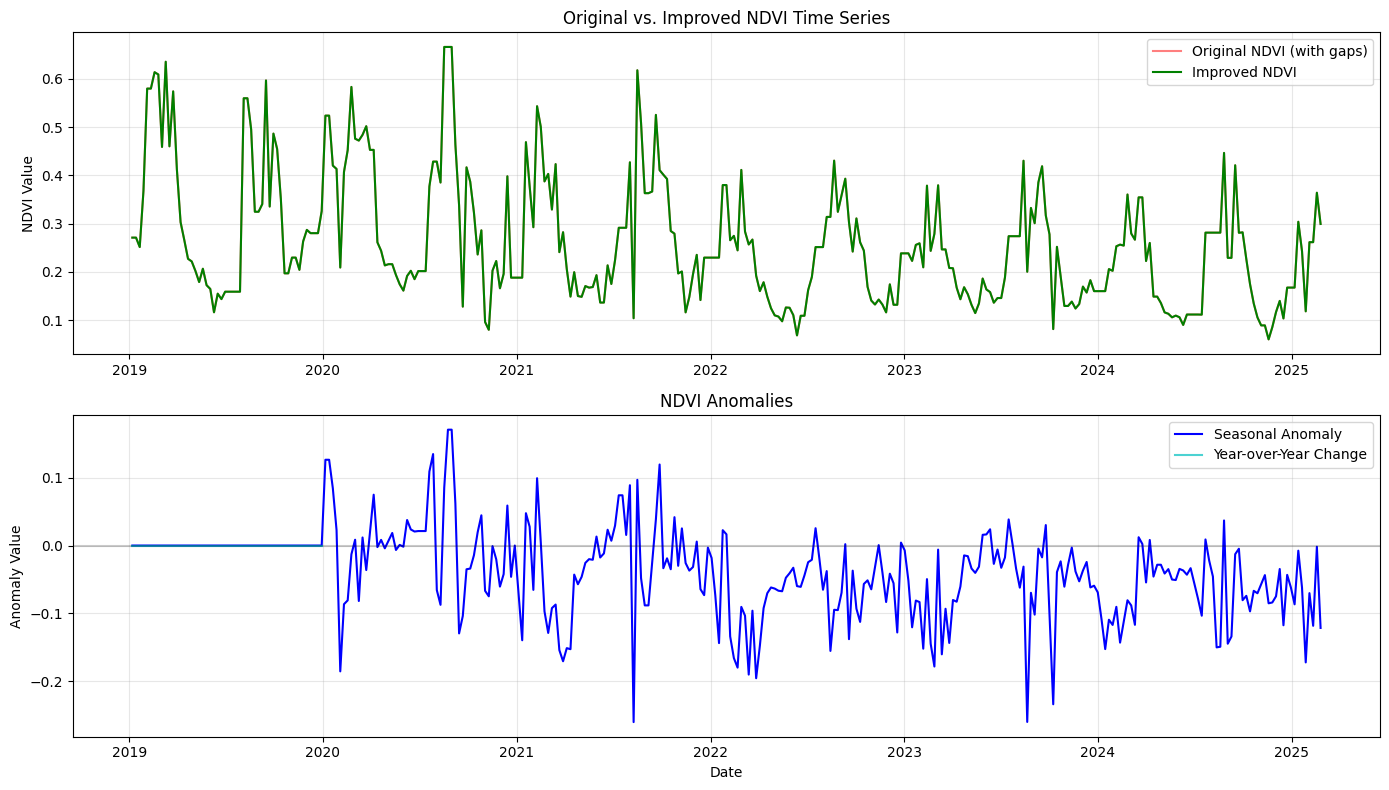

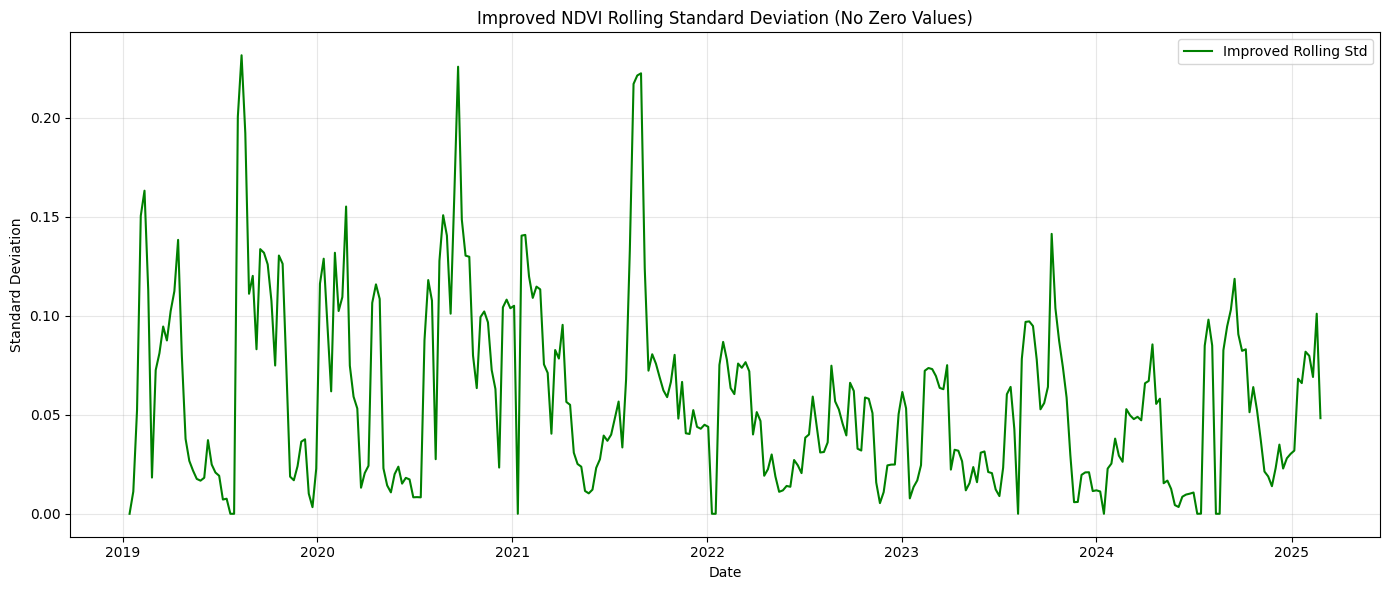

Data preprocessing complete!


,date,area_id,ndvi_mean,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,...,ndvi_same_week_last_year,ndvi_seasonal_avg,season_year,year_num,ndvi_mean_original,ndvi_seasonal_anomaly,ndvi_yoy_change,precip_sum_2week,precip_sum_4week,temp_seasonal_anomaly
0,2019-01-07,area_30.89N_75.95E,0.271056,18.959,4.209,11.018226,11.700001,11.700001,0.0,24.0,...,0.271056,0.271056,Winter_2019,2019,0.271056,0.0,0.0,11.700001,11.700001,0.433801
1,2019-01-14,area_30.89N_75.95E,0.271056,18.809,2.959,10.622690,5.900000,5.900000,0.0,11.0,...,0.271056,0.271056,Winter_2019,2019,0.271056,0.0,0.0,17.600001,17.600001,0.681802
2,2019-01-21,area_30.89N_75.95E,0.251496,20.709,3.209,11.608405,39.699997,39.699997,0.0,36.0,...,0.251496,0.251496,Winter_2019,2019,0.251496,0.0,0.0,45.599997,57.299998,0.571471
3,2019-01-28,area_30.89N_75.95E,0.367819,16.809,2.509,9.265250,1.000000,1.000000,0.0,6.0,...,0.367819,0.367819,Winter_2019,2019,0.367819,0.0,0.0,40.699997,58.299998,-1.778954
4,2019-02-04,area_30.89N_75.95E,0.579970,20.409,5.159,11.800369,8.500000,8.500000,0.0,23.0,...,0.579970,0.579970,Winter_2019,2019,0.579970,0.0,0.0,9.500000,55.099997,-0.521047


In [10]:
# --------------------------------------------------
# Data Preprocessing: Filling Gaps and Improving Consistency
# --------------------------------------------------

print("Starting data preprocessing to improve consistency...")

# Load the saved CSV file
area_id = f"area_{latitude:.2f}N_{longitude:.2f}E"
filename = f"{area_id}_ndvi_climate_training_data.csv"
df = pd.read_csv(filename)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# 1. Handle missing NDVI values (None values)
print(f"Missing NDVI values before processing: {df['ndvi_mean'].isna().sum()}")

# Sort by date to ensure proper time sequence
df = df.sort_values('date')

# Identify seasons for better interpolation
df['season_year'] = df['season'] + '_' + df['date'].dt.year.astype(str)
df['year_num'] = df['date'].dt.year

# First, try to fill missing values using seasonal patterns
# Group by week of year and interpolate within each group
df = df.set_index('date')

# Linear interpolation for short gaps (up to 3 weeks)
df['ndvi_mean_interp'] = df['ndvi_mean'].interpolate(method='linear', limit=3)

# For longer gaps, use seasonal patterns
# Calculate the average NDVI for each week of the year
weekly_avg = df.groupby('week_of_year')['ndvi_mean_interp'].mean()

# Fill remaining NaN values with the weekly average
for week in df[df['ndvi_mean_interp'].isna()].week_of_year.unique():
    if week in weekly_avg.index:
        mask = (df['ndvi_mean_interp'].isna()) & (df['week_of_year'] == week)
        df.loc[mask, 'ndvi_mean_interp'] = weekly_avg[week]

# If any values are still missing, use forward fill followed by backward fill
df['ndvi_mean_interp'] = df['ndvi_mean_interp'].fillna(method='ffill').fillna(method='bfill')

# Replace original ndvi_mean with interpolated values
df['ndvi_mean_original'] = df['ndvi_mean']  # Keep original for reference
df['ndvi_mean'] = df['ndvi_mean_interp']
df = df.drop(columns=['ndvi_mean_interp'])

print(f"Missing NDVI values after processing: {df['ndvi_mean'].isna().sum()}")

# 2. Recalculate rolling statistics with the filled data
print("Recalculating rolling statistics with filled data...")
df['ndvi_min_30day'] = df['ndvi_mean'].rolling(window=4, min_periods=1).min()
df['ndvi_max_30day'] = df['ndvi_mean'].rolling(window=4, min_periods=1).max()
df['ndvi_rolling_std'] = df['ndvi_mean'].rolling(window=4, min_periods=2).std()

# Replace any remaining zero std values with the minimum non-zero value
min_nonzero_std = df.loc[df['ndvi_rolling_std'] > 0, 'ndvi_rolling_std'].min()
df.loc[df['ndvi_rolling_std'] == 0, 'ndvi_rolling_std'] = min_nonzero_std * 0.5
print(f"Minimum non-zero rolling std: {min_nonzero_std}, used half of this to replace zeros")

# 3. Improve year-over-year patterns
print("Improving year-over-year patterns...")
# Recalculate same week last year with filled data
df['ndvi_same_week_last_year'] = df.groupby(['week_of_year'])['ndvi_mean'].shift(52)

# For the first year, use seasonal average instead of self-reference
first_year = df.index.year.min()
df.loc[df.index.year == first_year, 'ndvi_same_week_last_year'] = df['ndvi_seasonal_avg']

# 4. Recalculate seasonal average with improved data
print("Recalculating seasonal averages...")

# Fix: Create a unique index for each week-year combination to avoid duplicate labels
df_reset = df.reset_index()
seasonal_avgs = df_reset.groupby(['week_of_year', 'year_num'])['ndvi_mean'].mean().reset_index()

# Calculate expanding mean for each week of year
seasonal_avgs_expanded = []
for week in seasonal_avgs['week_of_year'].unique():
    week_data = seasonal_avgs[seasonal_avgs['week_of_year'] == week].sort_values('year_num')
    week_data['seasonal_avg'] = week_data['ndvi_mean'].expanding().mean()
    seasonal_avgs_expanded.append(week_data)

seasonal_avgs_expanded = pd.concat(seasonal_avgs_expanded)

# Merge back to original dataframe
df_reset = df_reset.merge(
    seasonal_avgs_expanded[['week_of_year', 'year_num', 'seasonal_avg']],
    on=['week_of_year', 'year_num'],
    how='left'
)

# Set date back as index
df = df_reset.set_index('date')
df['ndvi_seasonal_avg'] = df['seasonal_avg']
df = df.drop(columns=['seasonal_avg'])

# 5. Add anomaly features that might be useful for prediction
print("Adding anomaly features...")
# Calculate deviation from seasonal average
df['ndvi_seasonal_anomaly'] = df['ndvi_mean'] - df['ndvi_seasonal_avg']

# Calculate deviation from same week last year
df['ndvi_yoy_change'] = df['ndvi_mean'] - df['ndvi_same_week_last_year']

# 6. Add climate-related derived features
print("Adding climate-related derived features...")
# Calculate cumulative precipitation over different windows
df['precip_sum_2week'] = df['precipitation_sum'].rolling(window=2, min_periods=1).sum()
df['precip_sum_4week'] = df['precipitation_sum'].rolling(window=4, min_periods=1).sum()

# Calculate temperature anomalies
temp_avg_by_week = df.groupby('week_of_year')['temperature_2m_mean'].mean()
df['temp_seasonal_anomaly'] = df['temperature_2m_mean'] - df.week_of_year.map(temp_avg_by_week)

# Reset index to get date as a column again
df = df.reset_index()

# 7. Save the improved dataset
improved_filename = f"{area_id}_ndvi_climate_improved_data.csv"
df.to_csv(improved_filename, index=False)
print(f"Improved dataset saved to '{improved_filename}'")

# 8. Visualize the improvements
print("Creating visualization of the improvements...")
plt.figure(figsize=(14, 8))

# Plot original and improved NDVI
plt.subplot(2, 1, 1)
plt.plot(df['date'], df['ndvi_mean_original'], 'r-', alpha=0.5, label='Original NDVI (with gaps)')
plt.plot(df['date'], df['ndvi_mean'], 'g-', label='Improved NDVI')
plt.title('Original vs. Improved NDVI Time Series')
plt.ylabel('NDVI Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot the seasonal anomalies
plt.subplot(2, 1, 2)
plt.plot(df['date'], df['ndvi_seasonal_anomaly'], 'b-', label='Seasonal Anomaly')
plt.plot(df['date'], df['ndvi_yoy_change'], 'c-', alpha=0.7, label='Year-over-Year Change')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)
plt.title('NDVI Anomalies')
plt.xlabel('Date')
plt.ylabel('Anomaly Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{area_id}_ndvi_improvements.png")
plt.show()

# Create a comparison of original vs improved rolling statistics
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['ndvi_rolling_std'], 'g-', label='Improved Rolling Std')
plt.title('Improved NDVI Rolling Standard Deviation (No Zero Values)')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f"{area_id}_improved_rolling_std.png")
plt.show()

print("Data preprocessing complete!")

# Return the improved dataframe
df.head()

Dataset shape: (321, 29)

Missing values check:
ndvi_rolling_std              1
ndvi_same_week_last_year    269
ndvi_yoy_change             269
dtype: int64

Creating lag features...
Creating cumulative and moving average features...
Adding extreme weather indicators...
Calculating time since significant rainfall...
Adding cyclical time features...

Cleaning up any NaN values in new features...


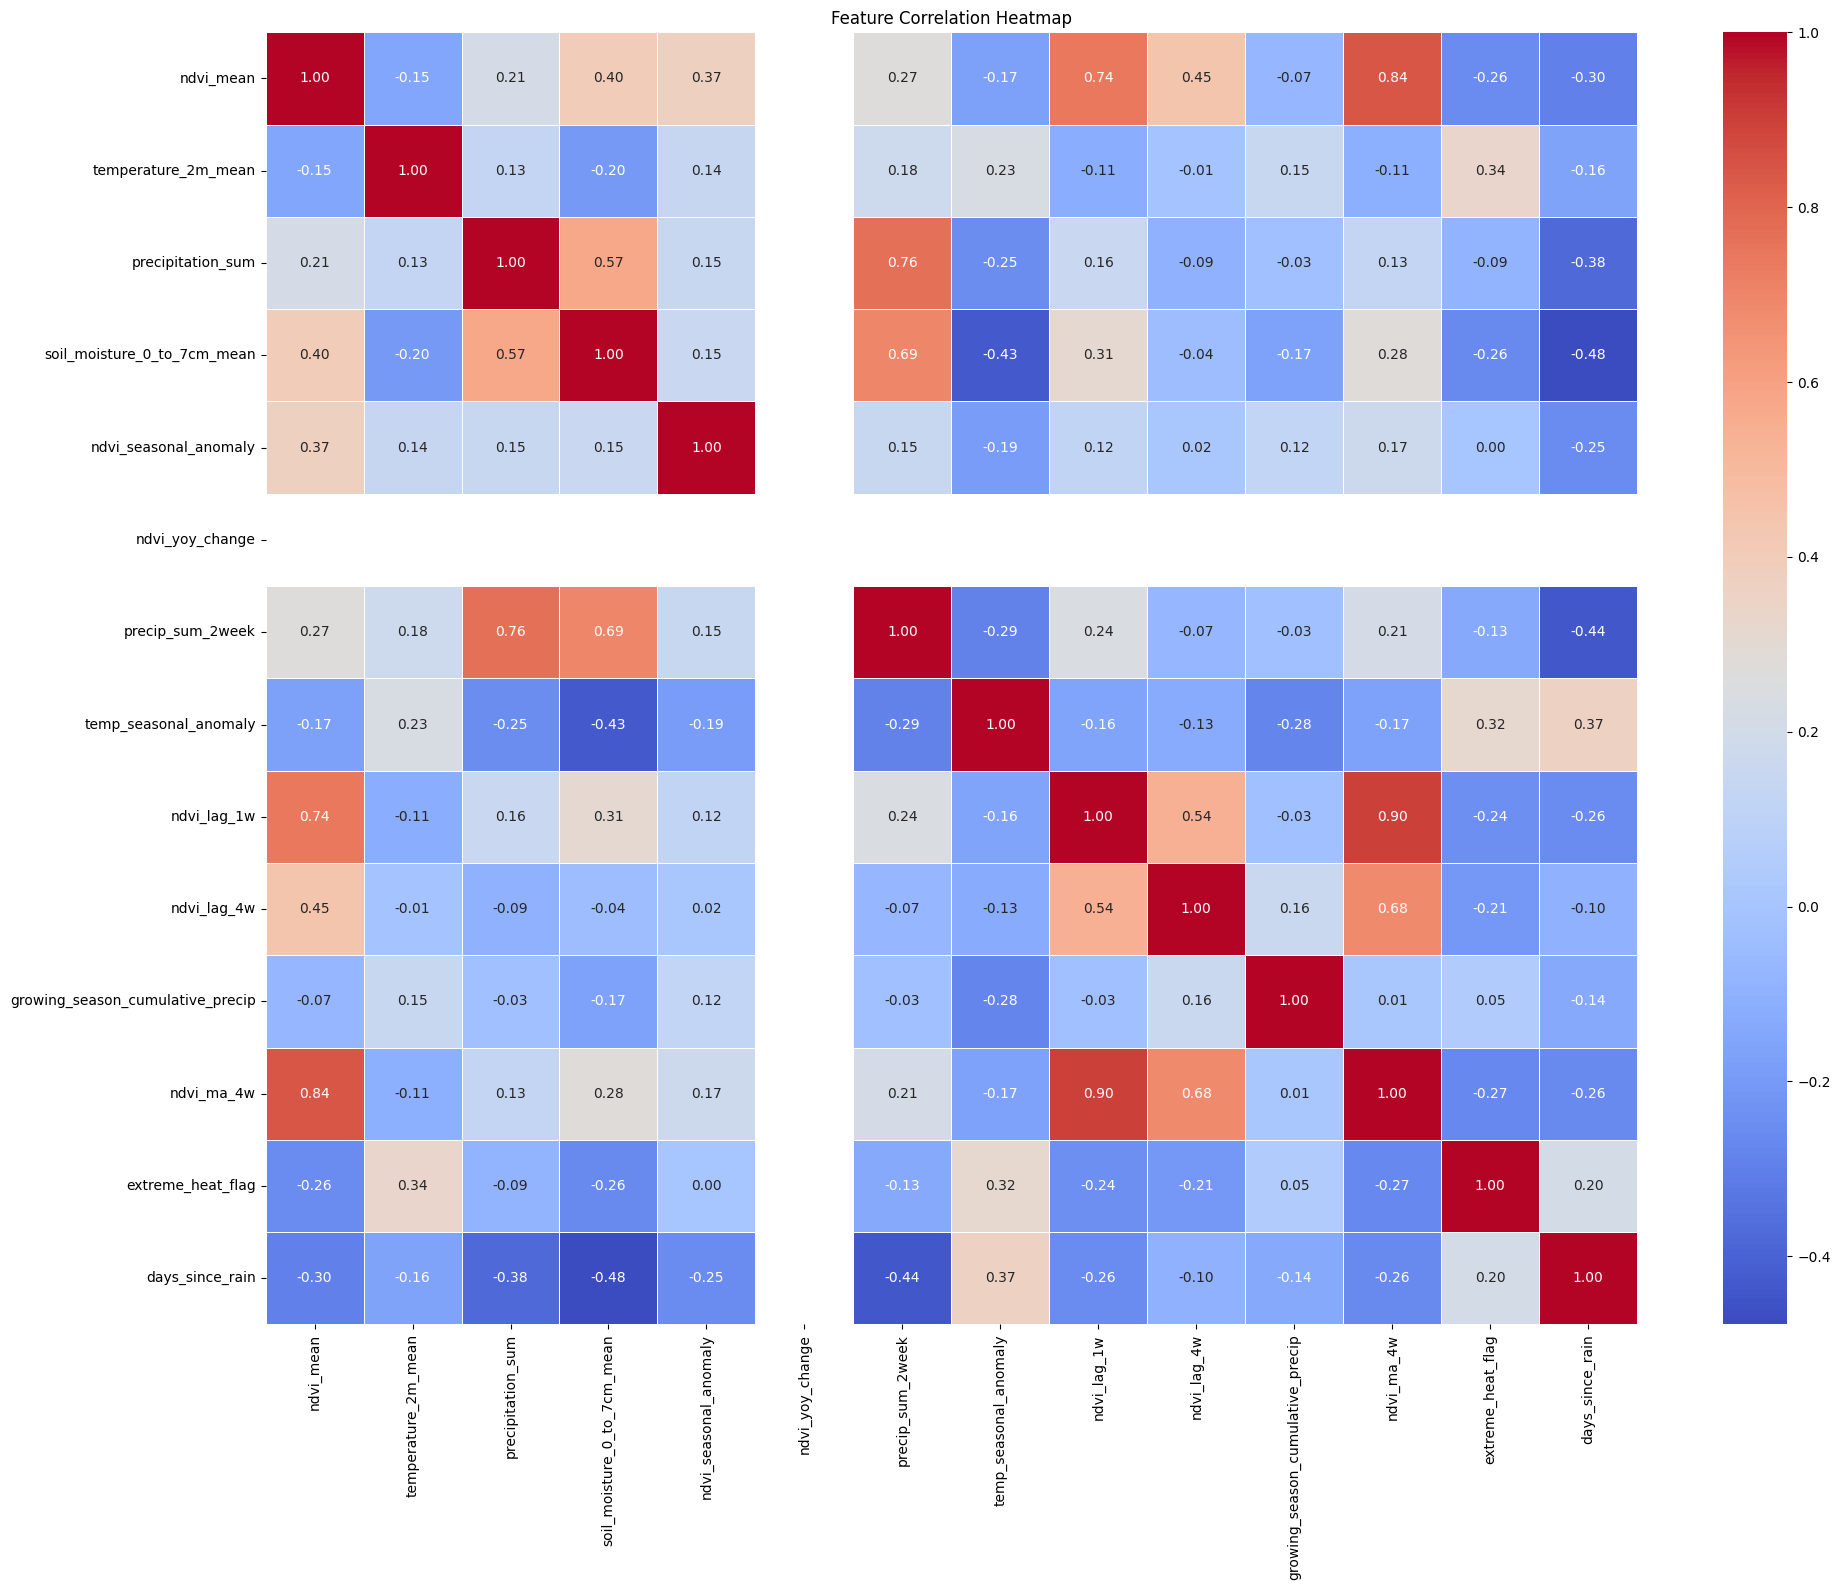


Enhanced dataset with 59 features saved to 'area_30.89N_75.95E_ndvi_climate_enhanced_data.csv'

Summary statistics of key features:
        ndvi_mean  ndvi_seasonal_anomaly  temperature_2m_mean  \
count  321.000000             321.000000           321.000000   
mean     0.260901              -0.037665            22.511185   
std      0.130704               0.064924             7.521112   
min      0.060166              -0.260212             6.477750   
25%      0.160151              -0.074111            15.499476   
50%      0.229652              -0.032376            24.640247   
75%      0.326071               0.000000            28.825666   
max      0.666251               0.170778            36.853046   

       precipitation_sum  growing_season_cumulative_precip  days_since_rain  
count         321.000000                        321.000000       321.000000  
mean           13.749221                         15.450156        14.545171  
std            25.155600                       

,date,area_id,ndvi_mean,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,...,extreme_heat_flag,extreme_cold_flag,heavy_rain_flag,potential_drought,days_since_rain,month_sin,month_cos,week_sin,week_cos,ndvi_is_outlier
0,2019-01-07,area_30.89N_75.95E,0.271056,18.959,4.209,11.018226,11.700001,11.700001,0.0,24.0,...,0,0,0,0,0,0.500000,0.866025,0.239316,0.970942,0
1,2019-01-14,area_30.89N_75.95E,0.271056,18.809,2.959,10.622690,5.900000,5.900000,0.0,11.0,...,0,1,0,0,0,0.500000,0.866025,0.354605,0.935016,0
2,2019-01-21,area_30.89N_75.95E,0.251496,20.709,3.209,11.608405,39.699997,39.699997,0.0,36.0,...,0,1,0,0,0,0.500000,0.866025,0.464723,0.885456,0
3,2019-01-28,area_30.89N_75.95E,0.367819,16.809,2.509,9.265250,1.000000,1.000000,0.0,6.0,...,0,1,0,0,7,0.500000,0.866025,0.568065,0.822984,0
4,2019-02-04,area_30.89N_75.95E,0.579970,20.409,5.159,11.800369,8.500000,8.500000,0.0,23.0,...,0,0,0,0,0,0.866025,0.500000,0.663123,0.748511,0


In [11]:
# Additional preprocessing for enhanced model performance
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the improved dataset
df = pd.read_csv(f"{area_id}_ndvi_climate_improved_data.csv")
df['date'] = pd.to_datetime(df['date'])
print(f"Dataset shape: {df.shape}")

# Check for any remaining missing values
missing_values = df.isnull().sum()
print("\nMissing values check:")
print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values found!")

# 1. Create lag features (important for time series prediction)
print("\nCreating lag features...")
for lag in [1, 2, 4, 8, 12]:  # 1, 2, 4, 8, 12 weeks lag
    df[f'ndvi_lag_{lag}w'] = df['ndvi_mean'].shift(lag)
    df[f'temp_lag_{lag}w'] = df['temperature_2m_mean'].shift(lag)
    df[f'precip_lag_{lag}w'] = df['precipitation_sum'].shift(lag)

# 2. Create cumulative and moving average features
print("Creating cumulative and moving average features...")
# Growing season cumulative precipitation
df['growing_season_start'] = ((df['month'] == 3) & (df['week_of_year'] == 10))
df['growing_season_cumulative_precip'] = 0

current_season = None
cumulative = 0
for i, row in df.iterrows():
    season_year = f"{row['season']}_{row['year_num']}"
    if row['growing_season_start']:
        current_season = season_year
        cumulative = 0

    if current_season is not None:
        if season_year == current_season:
            cumulative += row['precipitation_sum']
            df.at[i, 'growing_season_cumulative_precip'] = cumulative

# 3. Calculate moving averages for key variables
df['ndvi_ma_4w'] = df['ndvi_mean'].rolling(window=4).mean()
df['ndvi_ma_12w'] = df['ndvi_mean'].rolling(window=12).mean()
df['temp_ma_4w'] = df['temperature_2m_mean'].rolling(window=4).mean()

# 4. Add extreme weather indicators
print("Adding extreme weather indicators...")
# Temperature extremes (above 95th percentile or below 5th percentile)
temp_high_threshold = np.percentile(df['temperature_2m_max'], 95)
temp_low_threshold = np.percentile(df['temperature_2m_min'], 5)
df['extreme_heat_flag'] = (df['temperature_2m_max'] > temp_high_threshold).astype(int)
df['extreme_cold_flag'] = (df['temperature_2m_min'] < temp_low_threshold).astype(int)

# Heavy rainfall (above 95th percentile of non-zero precipitation)
precip_threshold = np.percentile(df['precipitation_sum'][df['precipitation_sum'] > 0], 95)
df['heavy_rain_flag'] = (df['precipitation_sum'] > precip_threshold).astype(int)

# 5. Calculate drought indicators (simple)
# Using 4-week cumulative precipitation below 10th percentile
precip_4w = df['precipitation_sum'].rolling(window=4).sum()
drought_threshold = np.percentile(precip_4w[~np.isnan(precip_4w)], 10)
df['potential_drought'] = (precip_4w < drought_threshold).astype(int)

# 6. Feature for "time since last significant rainfall"
print("Calculating time since significant rainfall...")
significant_rain_threshold = 5.0  # mm
df['days_since_rain'] = 0
days_count = 0

for i in range(len(df)):
    if df.iloc[i]['precipitation_sum'] >= significant_rain_threshold:
        days_count = 0
    else:
        days_count += 7  # Assuming weekly data

    df.iloc[i, df.columns.get_loc('days_since_rain')] = days_count

# 7. Add cyclical encoding of time features for better seasonality representation
print("Adding cyclical time features...")
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['week_sin'] = np.sin(2 * np.pi * df['week_of_year']/52)
df['week_cos'] = np.cos(2 * np.pi * df['week_of_year']/52)

# 8. Identify outliers in NDVI values
z_scores = stats.zscore(df['ndvi_mean'])
df['ndvi_is_outlier'] = (abs(z_scores) > 3).astype(int)

# Replace NaN values in newly created features
print("\nCleaning up any NaN values in new features...")
# Fill NaN in lag features with the median of each column
for col in df.columns:
    if df[col].isnull().any():
        if 'lag' in col or 'ma_' in col:
            # For time-based features, use forward fill first, then median
            df[col] = df[col].fillna(method='ffill')
            # If still have NaNs (at the beginning), use median
            if df[col].isnull().any():
                df[col] = df[col].fillna(df[col].median())
        else:
            # For other features, just use median
            df[col] = df[col].fillna(df[col].median())

# 9. Create feature correlation heatmap
plt.figure(figsize=(20, 16))
# Select a subset of columns to make the heatmap readable
feature_cols = ['ndvi_mean', 'temperature_2m_mean', 'precipitation_sum',
                'soil_moisture_0_to_7cm_mean', 'ndvi_seasonal_anomaly',
                'ndvi_yoy_change', 'precip_sum_2week', 'temp_seasonal_anomaly',
                'ndvi_lag_1w', 'ndvi_lag_4w', 'growing_season_cumulative_precip',
                'ndvi_ma_4w', 'extreme_heat_flag', 'days_since_rain']

corr = df[feature_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig(f"{area_id}_feature_correlation.png")
plt.show()

# 10. Save the enhanced dataset
enhanced_filename = f"{area_id}_ndvi_climate_enhanced_data.csv"
df.to_csv(enhanced_filename, index=False)
print(f"\nEnhanced dataset with {df.shape[1]} features saved to '{enhanced_filename}'")

# Display summary statistics of key features
print("\nSummary statistics of key features:")
print(df[['ndvi_mean', 'ndvi_seasonal_anomaly', 'temperature_2m_mean',
          'precipitation_sum', 'growing_season_cumulative_precip',
          'days_since_rain']].describe())

# Show the first few rows of the enhanced dataset
df.head()


------- Training Random Forest Model -------

Random Forest (Validation) Model Performance:
RMSE: 0.0519
MAE: 0.0415
R²: 0.5535

Random Forest (Test) Model Performance:
RMSE: 0.0771
MAE: 0.0662
R²: 0.3805
Random Forest training time: 0.41 seconds


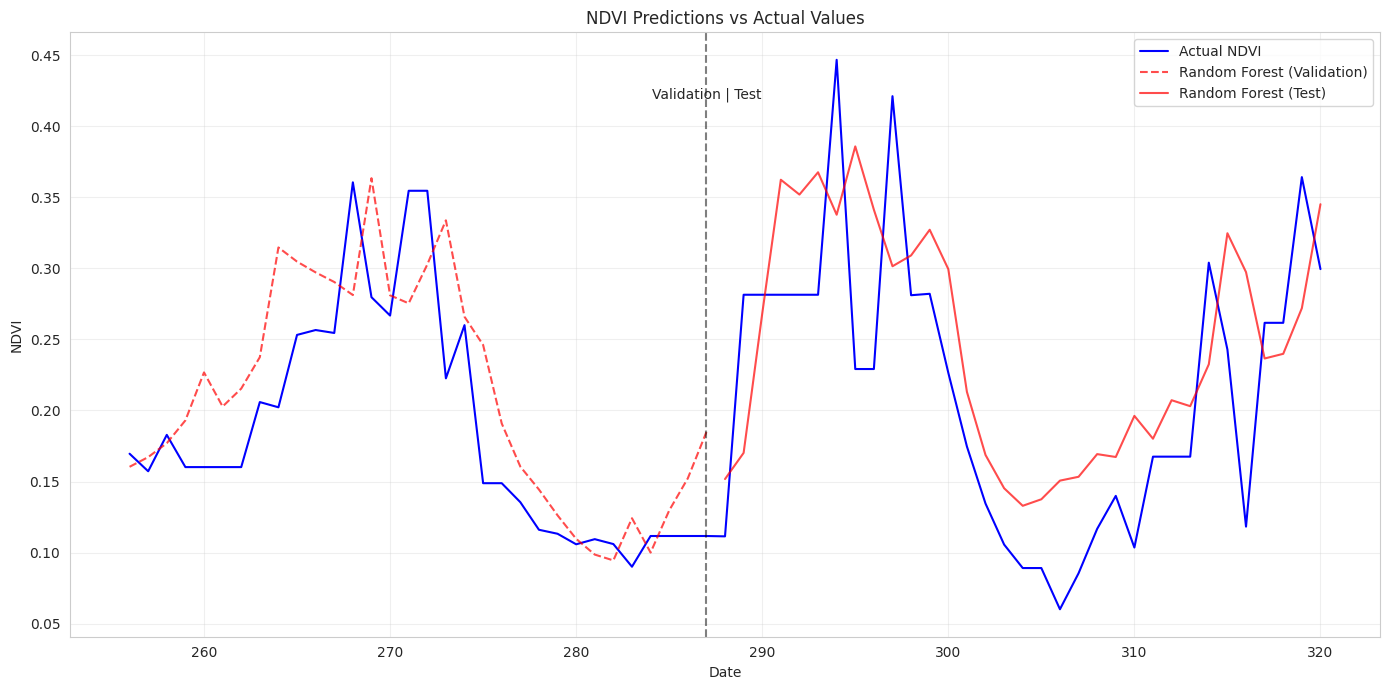


Would you like to perform hyperparameter tuning? (y/n)
y

------- Hyperparameter Tuning -------
This may take some time...

Best Random Forest parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30}

Tuned Random Forest (Validation) Model Performance:
RMSE: 0.0547
MAE: 0.0438
R²: 0.5043

Tuned Random Forest (Test) Model Performance:
RMSE: 0.0761
MAE: 0.0650
R²: 0.3963

Would you like to save the trained models? (y/n)
n

------- NDVI Prediction Model Summary -------
Random Forest Test RMSE: 0.0771, R²: 0.3805


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
import joblib
import warnings
import time

warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Assuming df is your DataFrame with the necessary features and target variable
# Define features and target variable
features = [
    'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
    'precipitation_sum', 'rain_sum', 'snowfall_sum',
    'soil_temperature_0_to_7cm_mean', 'soil_moisture_0_to_7cm_mean',
    'month', 'day_of_year', 'week_of_year', 'month_sin', 'month_cos',
    'week_sin', 'week_cos', 'ndvi_lag_1w', 'ndvi_lag_2w', 'ndvi_lag_4w',
    'ndvi_lag_8w', 'ndvi_lag_12w', 'growing_season_cumulative_precip'
]
target = 'ndvi_mean'

# Split the data into training, validation, and testing sets
X = df[features]
y = df[target]

# Split into training and test sets (80% train, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Further split the temporary set into validation and test sets (50% of temp for each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# ---------------------------------------------------------------------
# Model Training & Evaluation
# ---------------------------------------------------------------------

def evaluate_model(y_true, y_pred, name):
    """Calculate and print model evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{name} Model Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return rmse, mae, r2

# Random Forest
print("\n------- Training Random Forest Model -------")
start_time = time.time()

# Initially train with default parameters
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Make predictions
rf_val_pred = rf.predict(X_val)
rf_test_pred = rf.predict(X_test)

# Evaluate
rf_val_metrics = evaluate_model(y_val, rf_val_pred, "Random Forest (Validation)")
rf_test_metrics = evaluate_model(y_test, rf_test_pred, "Random Forest (Test)")

print(f"Random Forest training time: {time.time() - start_time:.2f} seconds")

# ---------------------------------------------------------------------
# Visualize Predictions
# ---------------------------------------------------------------------

# Combine validation and test predictions for visualization
val_df = pd.DataFrame({'date': X_val.index, 'ndvi_mean': y_val, 'predicted': rf_val_pred})
test_df = pd.DataFrame({'date': X_test.index, 'ndvi_mean': y_test, 'predicted': rf_test_pred})

# Plot actual vs predicted for the entire validation+test period
plt.figure(figsize=(14, 7))

# Actual values
plt.plot(pd.concat([val_df, test_df])['date'],
         pd.concat([val_df, test_df])['ndvi_mean'],
         'b-', label='Actual NDVI')

# Predictions - Random Forest
plt.plot(val_df['date'], rf_val_pred, 'r--', alpha=0.7, label='Random Forest (Validation)')
plt.plot(test_df['date'], rf_test_pred, 'r-', alpha=0.7, label='Random Forest (Test)')

# Add vertical line to separate validation and test sets
plt.axvline(x=val_df['date'].max(), color='k', linestyle='--', alpha=0.5)
plt.text(val_df['date'].max(), plt.ylim()[1]*0.9, 'Validation | Test', ha='center')

plt.title('NDVI Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{area_id}_model_predictions.png")
plt.show()

# ----------------------------------------------------------------------
# Hyperparameter Tuning (Optional - can be time-consuming)
# ----------------------------------------------------------------------

print("\nWould you like to perform hyperparameter tuning? (y/n)")
tune_choice = input()

if tune_choice.lower() == 'y':
    print("\n------- Hyperparameter Tuning -------")
    print("This may take some time...")

    # Define parameter grid
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # Random Forest tuning
    rf_tuned = RandomizedSearchCV(
        RandomForestRegressor(random_state=42),
        param_distributions=rf_param_grid,
        n_iter=10,
        cv=tscv,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )

    rf_tuned.fit(X_train, y_train)
    print("\nBest Random Forest parameters:", rf_tuned.best_params_)

    # Evaluate tuned models
    rf_tuned_val_pred = rf_tuned.predict(X_val)
    rf_tuned_test_pred = rf_tuned.predict(X_test)

    evaluate_model(y_val, rf_tuned_val_pred, "Tuned Random Forest (Validation)")
    evaluate_model(y_test, rf_tuned_test_pred, "Tuned Random Forest (Test)")

# ----------------------------------------------------------------------
# Save the models (optional)
# ----------------------------------------------------------------------

print("\nWould you like to save the trained models? (y/n)")
save_choice = input()

if save_choice.lower() == 'y':
    # Save model
    joblib.dump(rf, f"{area_id}_random_forest_model.joblib")
    print(f"Model saved with prefix: {area_id}_")

# Summary
print("\n------- NDVI Prediction Model Summary -------")
print(f"Random Forest Test RMSE: {rf_test_metrics[0]:.4f}, R²: {rf_test_metrics[2]:.4f}")

In [13]:
# Additional Feature Engineering
def create_features(df):
    """Create additional features for the model."""
    df['precipitation_2week'] = df['precipitation_sum'].rolling(window=2).sum()
    df['precipitation_4week'] = df['precipitation_sum'].rolling(window=4).sum()
    df['temperature_mean_4week'] = df['temperature_2m_mean'].rolling(window=4).mean()
    df['ndvi_ma_4w'] = df['ndvi_mean'].rolling(window=4).mean()
    df['ndvi_ma_12w'] = df['ndvi_mean'].rolling(window=12).mean()
    return df

# Apply feature engineering
df = create_features(df)

# Update features list
features = [
    'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
    'precipitation_sum', 'rain_sum', 'snowfall_sum',
    'soil_temperature_0_to_7cm_mean', 'soil_moisture_0_to_7cm_mean',
    'month', 'day_of_year', 'week_of_year', 'month_sin', 'month_cos',
    'week_sin', 'week_cos', 'ndvi_lag_1w', 'ndvi_lag_2w', 'ndvi_lag_4w',
    'ndvi_lag_8w', 'ndvi_lag_12w', 'growing_season_cumulative_precip',
    'precipitation_2week', 'precipitation_4week', 'temperature_mean_4week',
    'ndvi_ma_4w', 'ndvi_ma_12w'
]

# Split the data again after feature engineering
X = df[features]
y = df[target]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Hyperparameter Tuning with a wider search space
print("\n------- Hyperparameter Tuning -------")
print("This may take some time...")

# Define a wider parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Random Forest tuning
rf_tuned = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=20,  # Increase the number of iterations
    cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_train, y_train)
print("\nBest Random Forest parameters:", rf_tuned.best_params_)

# Evaluate tuned models
rf_tuned_val_pred = rf_tuned.predict(X_val)
rf_tuned_test_pred = rf_tuned.predict(X_test)

evaluate_model(y_val, rf_tuned_val_pred, "Tuned Random Forest (Validation)")
evaluate_model(y_test, rf_tuned_test_pred, "Tuned Random Forest (Test)")


------- Hyperparameter Tuning -------
This may take some time...

Best Random Forest parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}

Tuned Random Forest (Validation) Model Performance:
RMSE: 0.0267
MAE: 0.0197
R²: 0.8817

Tuned Random Forest (Test) Model Performance:
RMSE: 0.0542
MAE: 0.0422
R²: 0.6936


(0.05424697213795822, 0.04222766394074512, 0.6936388167871361)

Generating Random Forest learning curve...
Trees: 10, Train RMSE: 0.031709, Val RMSE: 0.035489
Trees: 20, Train RMSE: 0.030735, Val RMSE: 0.034128
Trees: 30, Train RMSE: 0.029329, Val RMSE: 0.031405
Trees: 40, Train RMSE: 0.028668, Val RMSE: 0.029424
Trees: 50, Train RMSE: 0.028216, Val RMSE: 0.028124
Trees: 60, Train RMSE: 0.027820, Val RMSE: 0.027637
Trees: 70, Train RMSE: 0.027826, Val RMSE: 0.027203
Trees: 80, Train RMSE: 0.027672, Val RMSE: 0.027156
Trees: 90, Train RMSE: 0.027660, Val RMSE: 0.027050
Trees: 100, Train RMSE: 0.027775, Val RMSE: 0.026935
Trees: 110, Train RMSE: 0.027810, Val RMSE: 0.027073
Trees: 120, Train RMSE: 0.027939, Val RMSE: 0.027075
Trees: 130, Train RMSE: 0.027987, Val RMSE: 0.027023
Trees: 140, Train RMSE: 0.027926, Val RMSE: 0.027150
Trees: 150, Train RMSE: 0.027907, Val RMSE: 0.026799
Trees: 160, Train RMSE: 0.028112, Val RMSE: 0.027198
Trees: 170, Train RMSE: 0.028108, Val RMSE: 0.027032
Trees: 180, Train RMSE: 0.028064, Val RMSE: 0.026798
Trees: 190, 

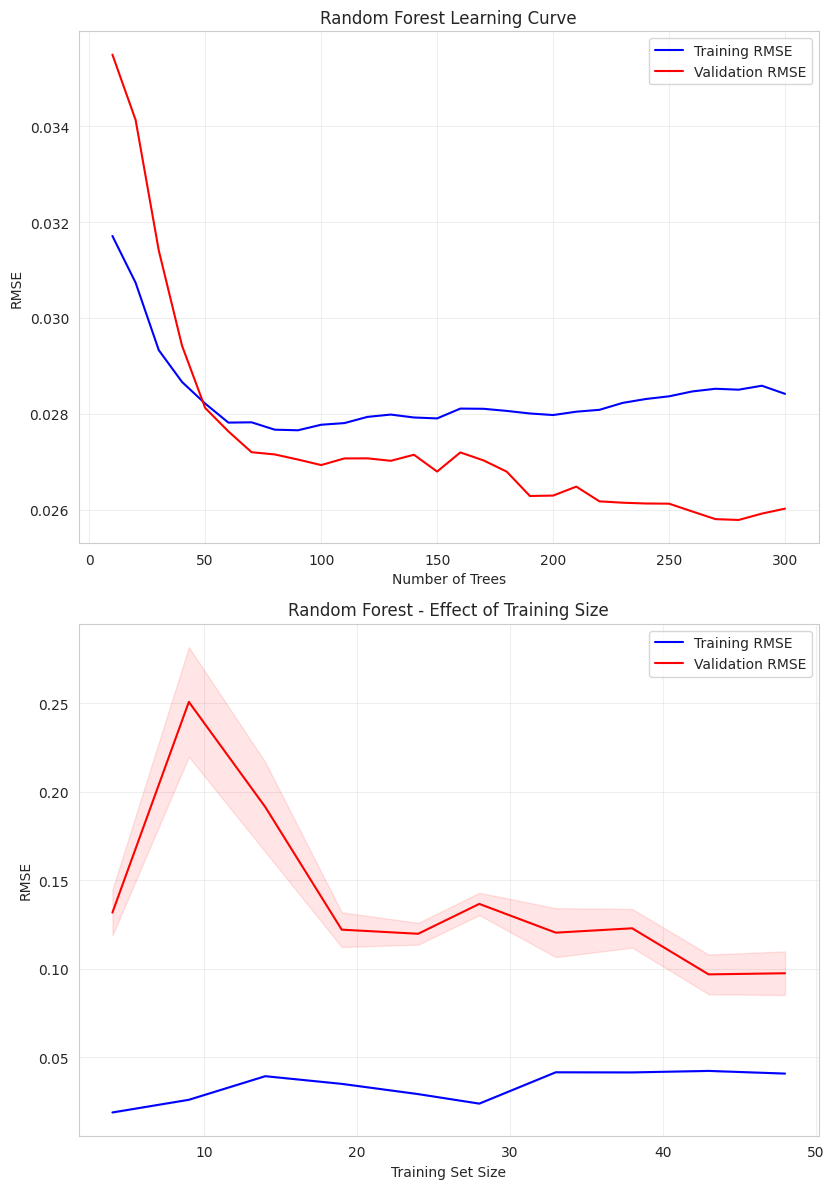


===== Model Overfitting/Underfitting Analysis =====

Random Forest:
Final training RMSE: 0.028419
Final validation RMSE: 0.026027
Gap (training - validation): 0.002393
Analysis: Model fits well - small gap between training and validation errors


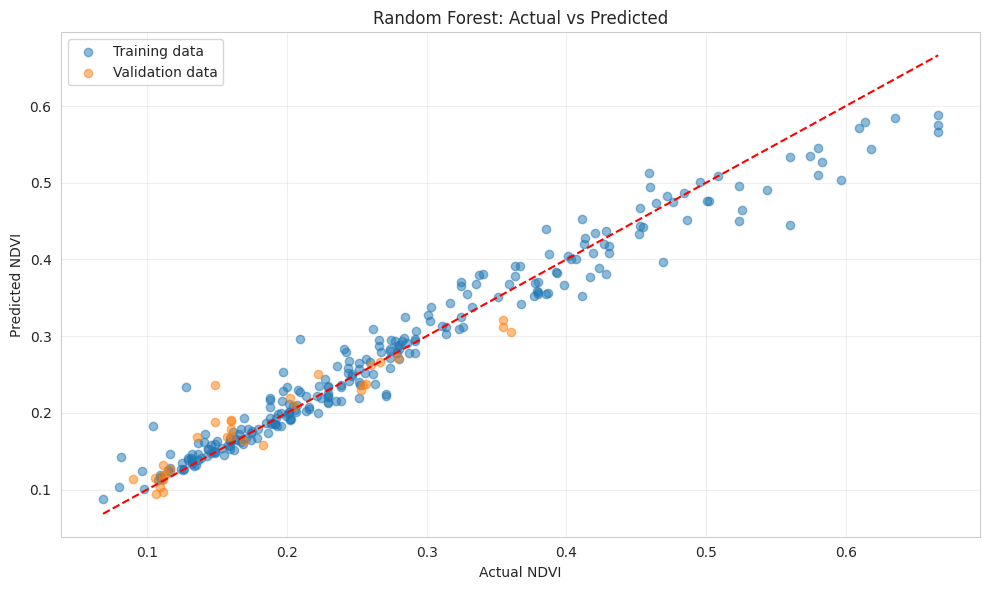

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve, TimeSeriesSplit

# Set up plotting
plt.figure(figsize=(16, 12))

# =============== Random Forest Learning Curve ===============
print("Generating Random Forest learning curve...")

# Function to evaluate model with different numbers of trees
def evaluate_rf_trees(X_train, y_train, X_val, y_val, max_trees=300, step=10):
    train_scores = []
    val_scores = []
    tree_counts = list(range(10, max_trees + 1, step))

    for n_trees in tree_counts:
        # Train model with specific number of trees
        rf = RandomForestRegressor(n_estimators=n_trees, random_state=42)
        rf.fit(X_train, y_train)

        # Calculate RMSE on train and validation sets
        train_pred = rf.predict(X_train)
        val_pred = rf.predict(X_val)

        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

        train_scores.append(train_rmse)
        val_scores.append(val_rmse)

        print(f"Trees: {n_trees}, Train RMSE: {train_rmse:.6f}, Val RMSE: {val_rmse:.6f}")

    return tree_counts, train_scores, val_scores

# Generate learning curve data
tree_counts, rf_train_scores, rf_val_scores = evaluate_rf_trees(X_train, y_train, X_val, y_val)

# Plot Random Forest learning curve
plt.subplot(2, 2, 1)
plt.plot(tree_counts, rf_train_scores, 'b-', label='Training RMSE')
plt.plot(tree_counts, rf_val_scores, 'r-', label='Validation RMSE')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('Random Forest Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# =============== Training Size Learning Curve ===============
print("\nGenerating training size learning curve...")

# Function to create learning curves with different training sizes
def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        train_sizes=train_sizes, cv=cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1)

    # Calculate mean and std for training and validation scores
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    return train_sizes, train_scores_mean, train_scores_std, val_scores_mean, val_scores_std

# Create TimeSeriesSplit for time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define and fit the final Random Forest model
rf_final = RandomForestRegressor(n_estimators=100, random_state=42)  # Define rf_final here
rf_final.fit(X_train, y_train)  # Fit the model on the training data

# Plot learning curve for Random Forest
train_sizes, rf_train_mean, rf_train_std, rf_val_mean, rf_val_std = plot_learning_curve(
    rf_final, np.vstack((X_train, X_val)), np.concatenate((y_train, y_val)), tscv)

plt.subplot(2, 2, 3)
plt.plot(train_sizes, rf_train_mean, 'b-', label='Training RMSE')
plt.plot(train_sizes, rf_val_mean, 'r-', label='Validation RMSE')
plt.fill_between(train_sizes, rf_train_mean - rf_train_std, rf_train_mean + rf_train_std, alpha=0.1, color='b')
plt.fill_between(train_sizes, rf_val_mean - rf_val_std, rf_val_mean + rf_val_std, alpha=0.1, color='r')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Random Forest - Effect of Training Size')
plt.legend()
plt.grid(True, alpha=0.3)

# Finalize plot
plt.tight_layout()
plt.savefig(f"{area_id}_learning_curves.png", dpi=300)
plt.show()

# =============== Analysis ===============
print("\n===== Model Overfitting/Underfitting Analysis =====")

# Calculate final gap between train and validation performance
rf_train_val_gap = rf_train_scores[-1] - rf_val_scores[-1]

print("\nRandom Forest:")
print(f"Final training RMSE: {rf_train_scores[-1]:.6f}")
print(f"Final validation RMSE: {rf_val_scores[-1]:.6f}")
print(f"Gap (training - validation): {rf_train_val_gap:.6f}")

if rf_train_scores[-1] > 0.05 and rf_val_scores[-1] > 0.05:
    print("Analysis: Model may be UNDERFITTING - both training and validation errors are high")
elif rf_train_val_gap < -0.03:
    print("Analysis: Validation error is lower than training error - unusual pattern, check data")
elif rf_train_val_gap > 0.03:
    print("Analysis: Model shows signs of OVERFITTING - training error is much lower than validation")
else:
    print("Analysis: Model fits well - small gap between training and validation errors")

# =============== Goodness of Fit Analysis ===============
plt.figure(figsize=(10, 6))

# Plot actual vs predicted for Random Forest
rf_final_train_pred = rf_final.predict(X_train)
rf_final_val_pred = rf_final.predict(X_val)

plt.scatter(y_train, rf_final_train_pred, alpha=0.5, label='Training data')
plt.scatter(y_val, rf_final_val_pred, alpha=0.5, label='Validation data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
plt.xlabel('Actual NDVI')
plt.ylabel('Predicted NDVI')
plt.title('Random Forest: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{area_id}_goodness_of_fit.png", dpi=300)
plt.show()

In [15]:
import joblib

# Save the trained Random Forest model
model_filename = f"{area_id}_random_forest_model.joblib"
joblib.dump(rf_final, model_filename)
print(f"Model saved to '{model_filename}'")

Model saved to 'area_30.89N_75.95E_random_forest_model.joblib'


In [27]:
pip install shap

In [16]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf_final)

# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)

# Visualize the SHAP values for all features
shap.initjs()  # Initialize JavaScript visualization in Jupyter Notebook

# Summary plot for all features
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

# Generate dependence plots for each feature
for feature in X_train.columns:
    shap.dependence_plot(feature, shap_values, X_train)

Output hidden; open in https://colab.research.google.com to view.

In [20]:
# Cell 1: Load the CSV and Linear Regression Model

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the enhanced dataset from a CSV file
file_path = '/content/area_30.89N_75.95E_ndvi_climate_enhanced_data.csv'  # Update this with the actual path to your CSV file
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify the data
print(df.head())

# Define features for Linear Regression
features_lr = [
    'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
    'precipitation_sum', 'rain_sum', 'snowfall_sum',
    'soil_temperature_0_to_7cm_mean', 'soil_moisture_0_to_7cm_mean',
    'month', 'day_of_year', 'week_of_year', 'month_sin', 'month_cos',
    'week_sin', 'week_cos', 'ndvi_lag_1w', 'ndvi_lag_4w', 'ndvi_ma_4w',
    'ndvi_ma_12w', 'ndvi_lag_8w', 'growing_season_cumulative_precip'
]
target = 'ndvi_mean'

# Split the data into training and testing sets
X = df[features_lr]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize and fit the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print evaluation metrics
print("Linear Regression Model Performance:")
print(f"Training RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

         date             area_id  ndvi_mean  temperature_2m_max  \
0  2019-01-07  area_30.89N_75.95E   0.271056              18.959   
1  2019-01-14  area_30.89N_75.95E   0.271056              18.809   
2  2019-01-21  area_30.89N_75.95E   0.251496              20.709   
3  2019-01-28  area_30.89N_75.95E   0.367819              16.809   
4  2019-02-04  area_30.89N_75.95E   0.579970              20.409   

   temperature_2m_min  temperature_2m_mean  precipitation_sum   rain_sum  \
0               4.209            11.018226          11.700001  11.700001   
1               2.959            10.622690           5.900000   5.900000   
2               3.209            11.608405          39.699997  39.699997   
3               2.509             9.265250           1.000000   1.000000   
4               5.159            11.800369           8.500000   8.500000   

   snowfall_sum  precipitation_hours  ...  extreme_heat_flag  \
0           0.0                 24.0  ...                  0   
1     

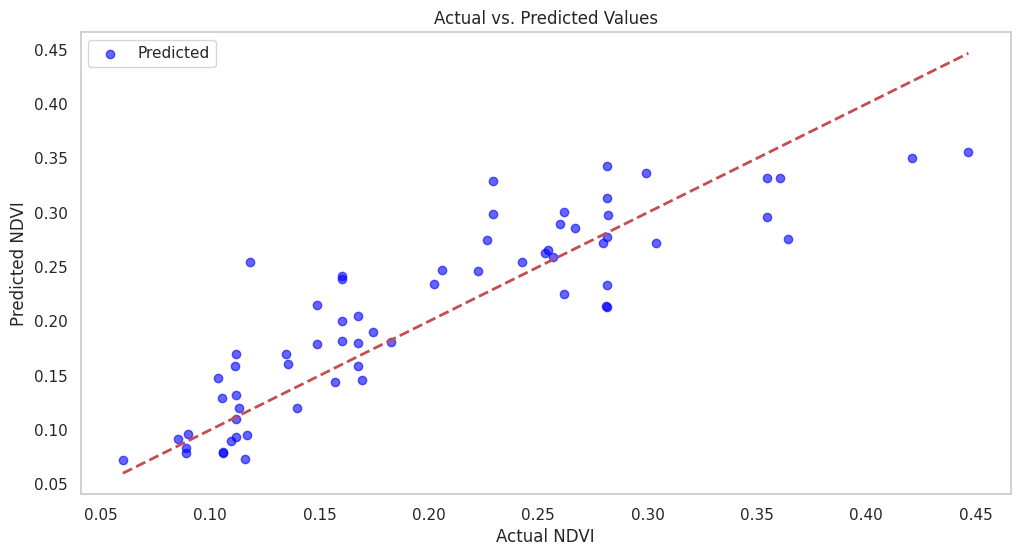

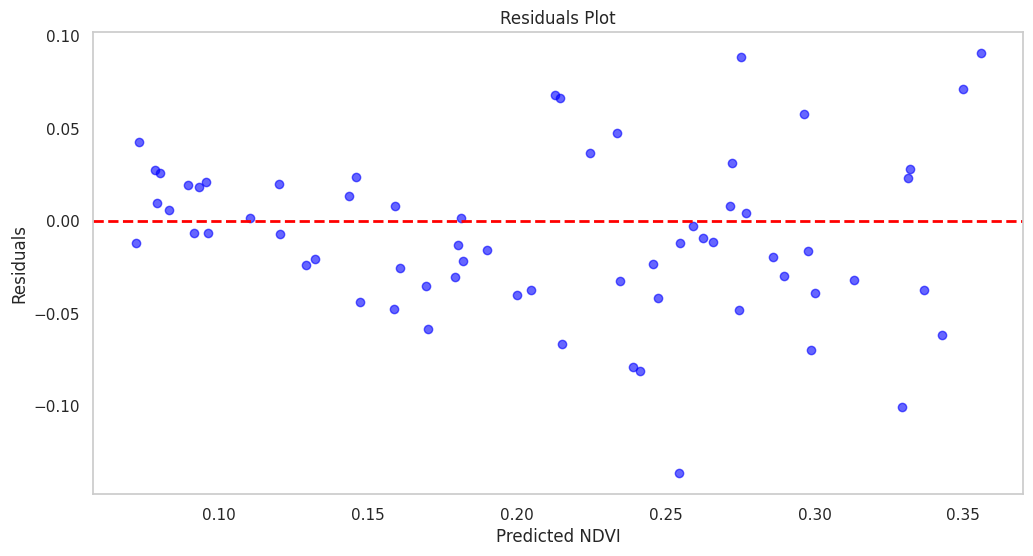

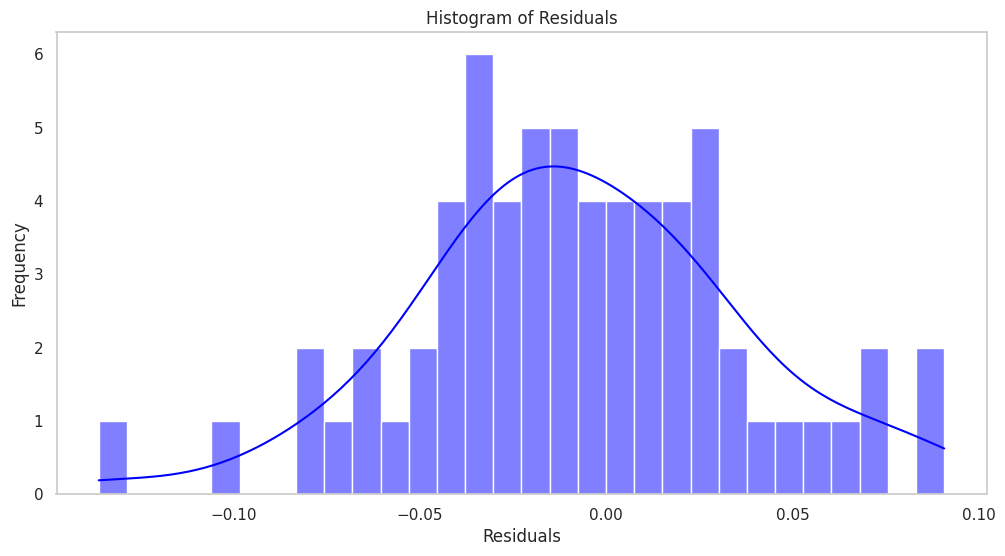

In [21]:
# Visualization of Linear Regression Model Performance

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style='whitegrid')

# 1. Actual vs. Predicted Plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Predicted', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual NDVI')
plt.ylabel('Predicted NDVI')
plt.legend()
plt.grid()
plt.show()

# 2. Residuals Plot
plt.figure(figsize=(12, 6))
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', lw=2)  # Horizontal line at 0
plt.title('Residuals Plot')
plt.xlabel('Predicted NDVI')
plt.ylabel('Residuals')
plt.grid()
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=30, kde=True, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [26]:
# Cell 1: LSTM Model Implementation

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the enhanced dataset from a CSV file
file_path = '/content/area_30.89N_75.95E_ndvi_climate_enhanced_data.csv'  # Update this with the actual path to your CSV file
df = pd.read_csv(file_path)

# Define features for LSTM
features_lstm = [
    'ndvi_ma_4w', 'ndvi_lag_1w', 'ndvi_lag_4w',
    'ndvi_ma_12w', 'ndvi_lag_8w', 'soil_moisture_0_to_7cm_mean',
    'temp_lag_4w'
]
target = 'ndvi_mean'

# Prepare the data
X = df[features_lstm].values
y = df[target].values

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for LSTM [samples, time steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))  # Output layer

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with validation data
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_train_pred = lstm_model.predict(X_train)
y_test_pred = lstm_model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print evaluation metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0877 - val_loss: 0.0312
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0564 - val_loss: 0.0179
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0356 - val_loss: 0.0088
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0162 - val_loss: 0.0082
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0174 - val_loss: 0.0103
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0147 - val_loss: 0.0079
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0118 - val_loss: 0.0064
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112 - val_loss: 0.0060
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0113 - val_loss: 0.0061
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0111 - val_loss: 0.0060
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0108 - val_loss: 0.0053
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0086 - val_loss: 0.0048
E

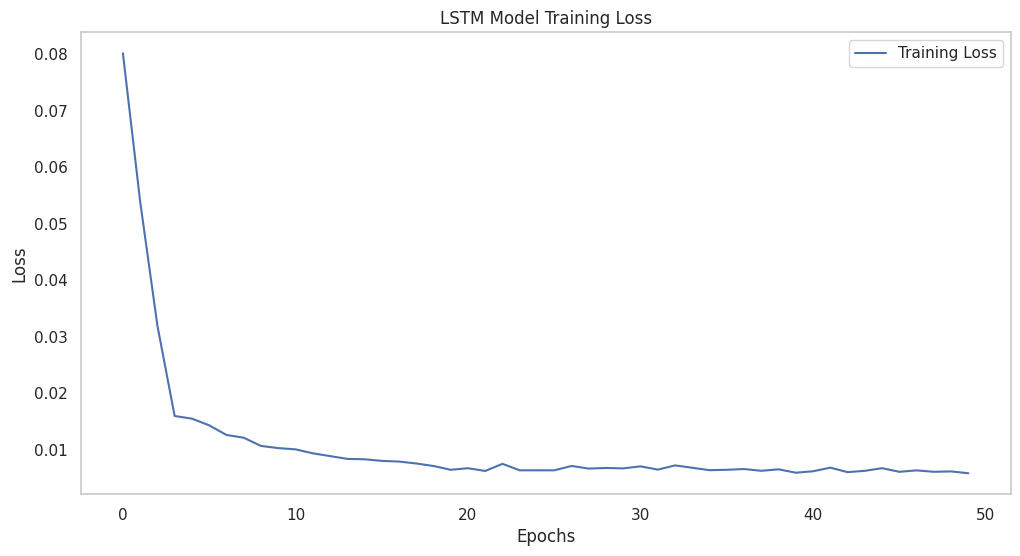

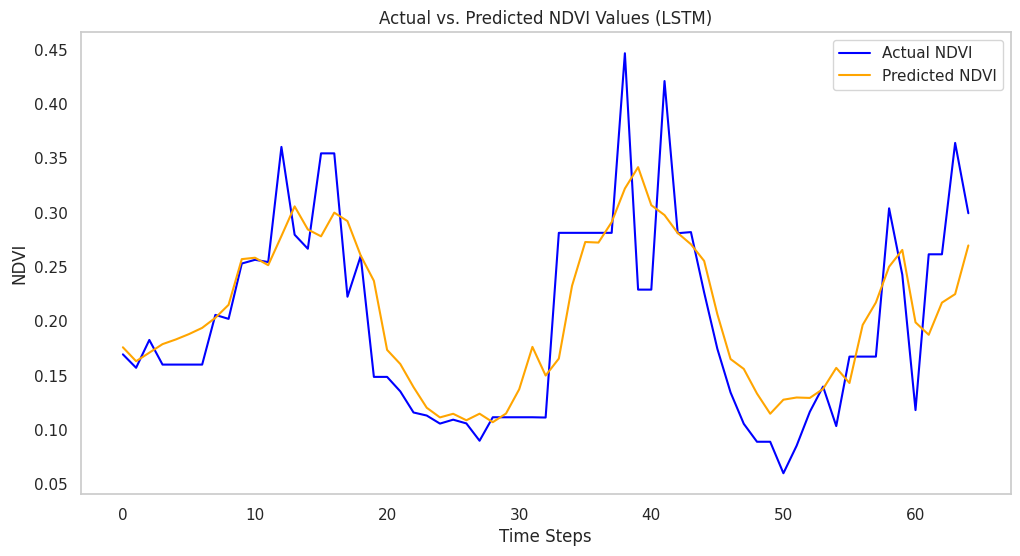

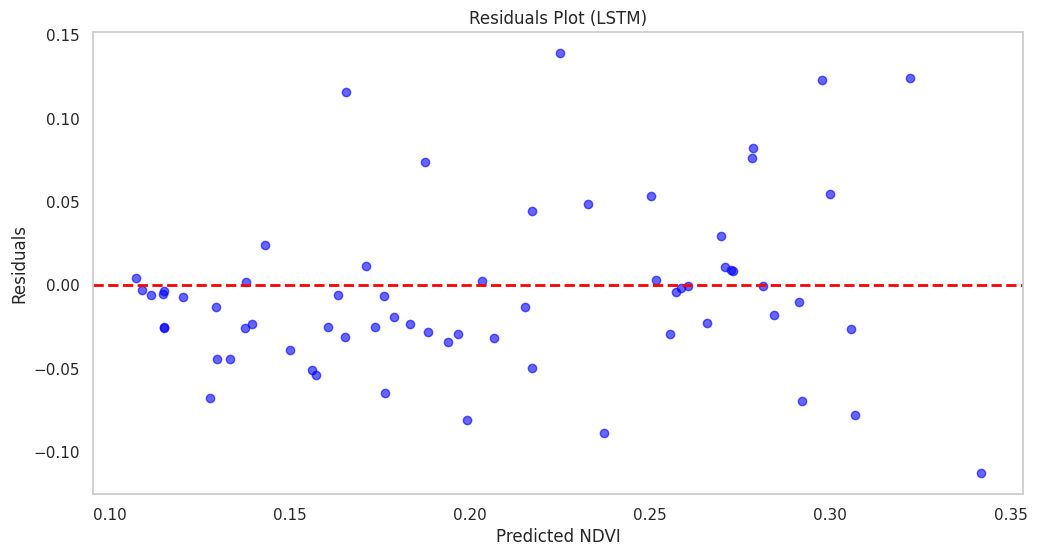

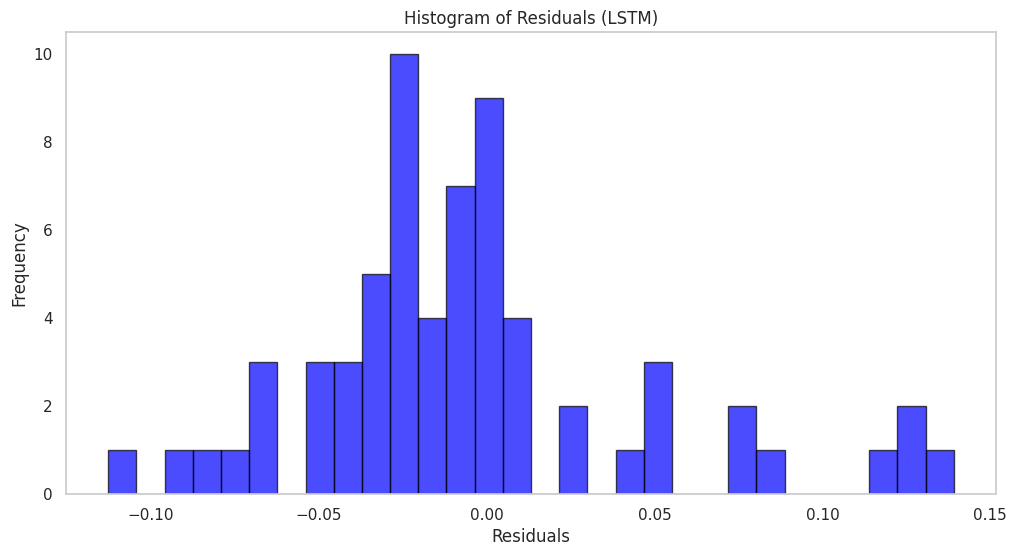

In [27]:
# Cell 2: Visualization of LSTM Model Performance

# Visualization of LSTM Model Performance

import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('LSTM Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 1. Actual vs. Predicted Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual NDVI', color='blue')
plt.plot(y_test_pred, label='Predicted NDVI', color='orange')
plt.title('Actual vs. Predicted NDVI Values (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('NDVI')
plt.legend()
plt.grid()
plt.show()

# 2. Residuals Plot
plt.figure(figsize=(12, 6))
residuals = y_test - y_test_pred.flatten()  # Flatten the predictions to match the shape
plt.scatter(y_test_pred, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', lw=2)  # Horizontal line at 0
plt.title('Residuals Plot (LSTM)')
plt.xlabel('Predicted NDVI')
plt.ylabel('Residuals')
plt.grid()
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Residuals (LSTM)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [36]:
# Cell 1: LSTM Model Implementation with Accuracy

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the enhanced dataset from a CSV file
file_path = '/content/area_30.89N_75.95E_ndvi_climate_enhanced_data.csv'  # Update this with the actual path to your CSV file
df = pd.read_csv(file_path)

# Define features for LSTM
features_lstm = [
    'ndvi_ma_4w', 'ndvi_lag_1w', 'ndvi_lag_4w',
    'ndvi_ma_12w', 'ndvi_lag_8w', 'soil_moisture_0_to_7cm_mean',
    'temp_lag_4w'
]
target = 'ndvi_mean'

# Prepare the data
X = df[features_lstm].values
y = df[target].values

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for LSTM [samples, time steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))  # Output layer

# Compile the model with mean squared error loss and mean absolute error for accuracy
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model with validation data
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_train_pred = lstm_model.predict(X_train)
y_test_pred = lstm_model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print evaluation metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0942 - mae: 0.2747 - val_loss: 0.0346 - val_mae: 0.1635
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0630 - mae: 0.2143 - val_loss: 0.0216 - val_mae: 0.1187
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0458 - mae: 0.1688 - val_loss: 0.0112 - val_mae: 0.0817
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0209 - mae: 0.1020 - val_loss: 0.0071 - val_mae: 0.0708
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0151 - mae: 0.0933 - val_loss: 0.0100 - val_mae: 0.0843
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0139 - mae: 0.0991 - val_loss: 0.0088 - val_mae: 0.0799
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0127 - mae: 0.0919 - val_loss: 0.0068 - val_mae: 0.0705
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0115 - mae: 0.0812 - val_loss: 0.0061 - val_mae: 0.0666
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0117 - mae: 0.0825 - 

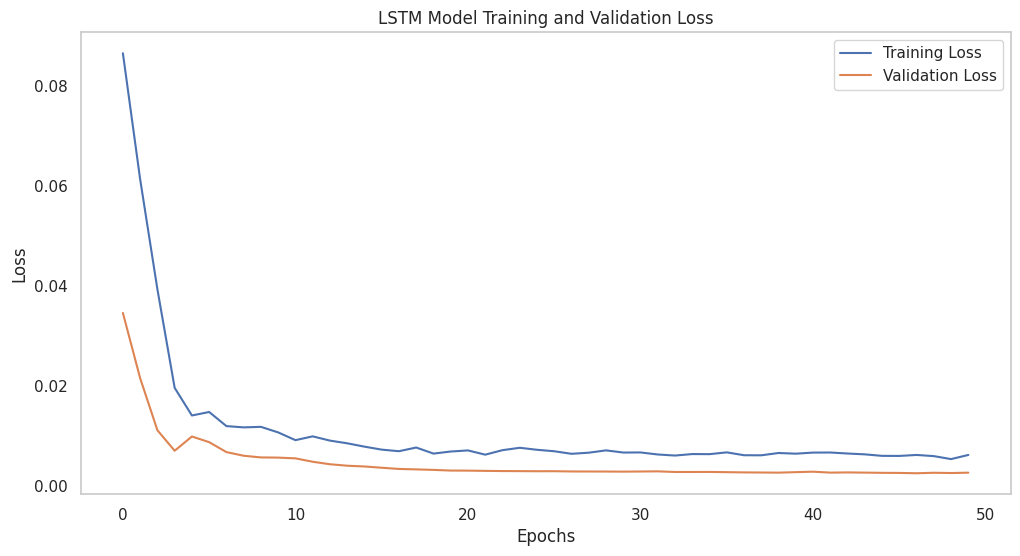

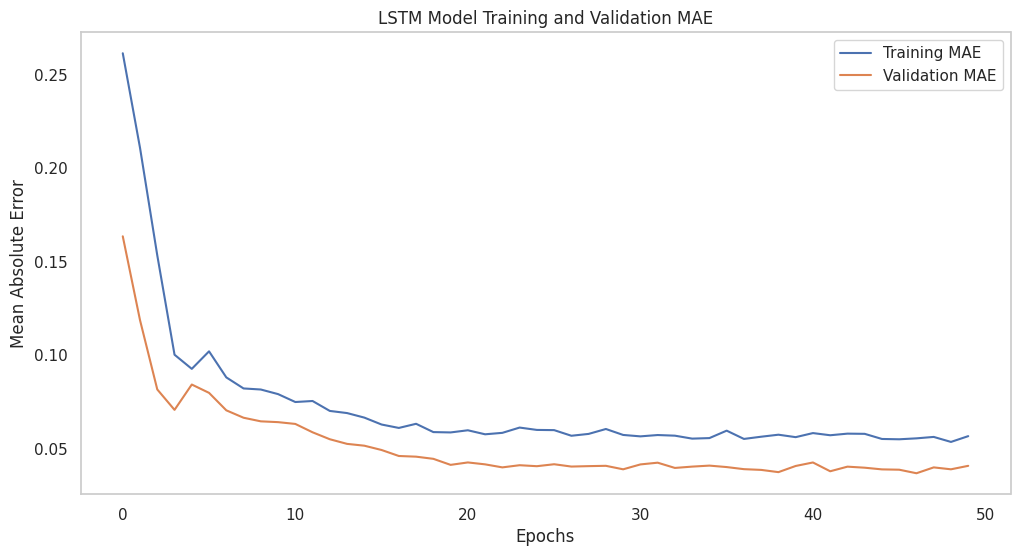

Testing Loss (MSE): 0.0027
Testing MAE: 0.0912


In [37]:
# Cell 2: Visualization of Loss and Accuracy

# Visualization of LSTM Model Performance

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation MAE (Mean Absolute Error) as a proxy for accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('LSTM Model Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid()
plt.show()

# Testing Loss and Accuracy
# Since we don't have a built-in accuracy metric for regression, we will use MAE for testing as well
test_loss = mean_squared_error(y_test, y_test_pred)
test_mae = np.mean(np.abs(y_test - y_test_pred))

# Print testing metrics
print(f"Testing Loss (MSE): {test_loss:.4f}")
print(f"Testing MAE: {test_mae:.4f}")

In [39]:
# Cell 1: LSTM Model Implementation with RMSE

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the enhanced dataset from a CSV file
file_path = '/content/area_30.89N_75.95E_ndvi_climate_enhanced_data.csv'  # Update this with the actual path to your CSV file
df = pd.read_csv(file_path)

# Define features for LSTM
features_lstm = [
    'ndvi_ma_4w', 'ndvi_lag_1w', 'ndvi_lag_4w',
    'ndvi_ma_12w', 'ndvi_lag_8w', 'soil_moisture_0_to_7cm_mean',
    'temp_lag_4w'
]
target = 'ndvi_mean'

# Prepare the data
X = df[features_lstm].values
y = df[target].values

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for LSTM [samples, time steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))  # Output layer

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with validation data
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_train_pred = lstm_model.predict(X_train)
y_test_pred = lstm_model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print evaluation metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0836 - val_loss: 0.0277
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0538 - val_loss: 0.0142
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0266 - val_loss: 0.0074
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0144 - val_loss: 0.0088
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0141 - val_loss: 0.0094
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0131 - val_loss: 0.0069
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0106 - val_loss: 0.0060
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0119 - val_loss: 0.0058
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0105 - val_loss: 0.0053
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0094 - val_loss: 0.0047
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0100 - val_loss: 0.0044


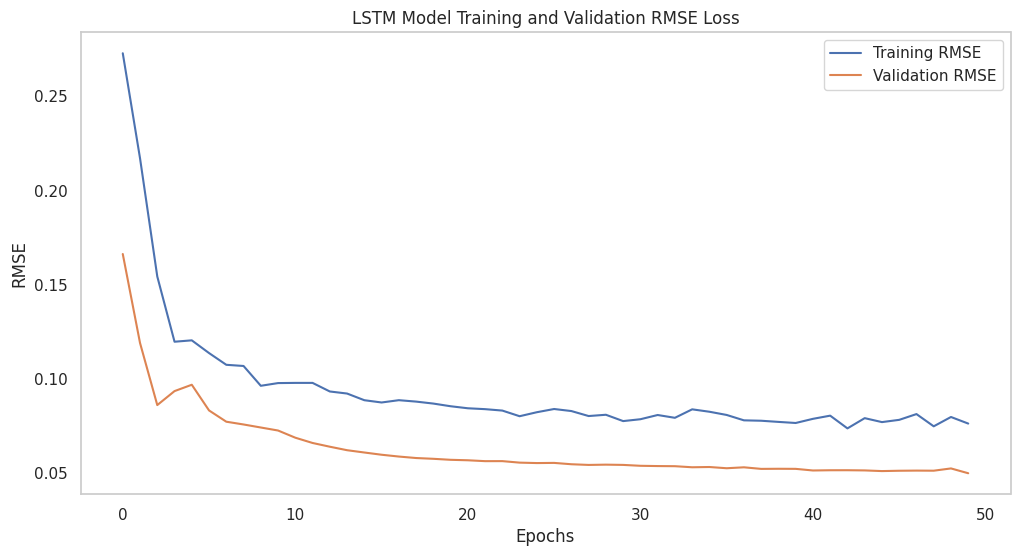

In [41]:
# Cell 2: Visualization of RMSE

# Visualization of LSTM Model Performance

# Calculate RMSE for training and validation
train_rmse_values = np.sqrt(history.history['loss'])  # Training RMSE
val_rmse_values = np.sqrt(history.history['val_loss'])  # Validation RMSE

# Plot training and validation RMSE
plt.figure(figsize=(12, 6))
plt.plot(train_rmse_values, label='Training RMSE')
plt.plot(val_rmse_values, label='Validation RMSE')
plt.title('LSTM Model Training and Validation RMSE Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

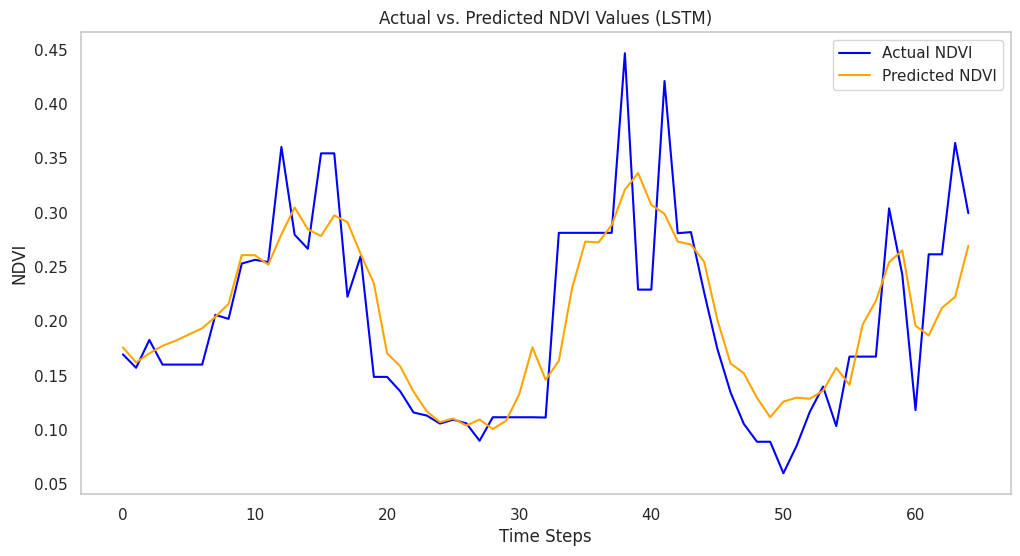

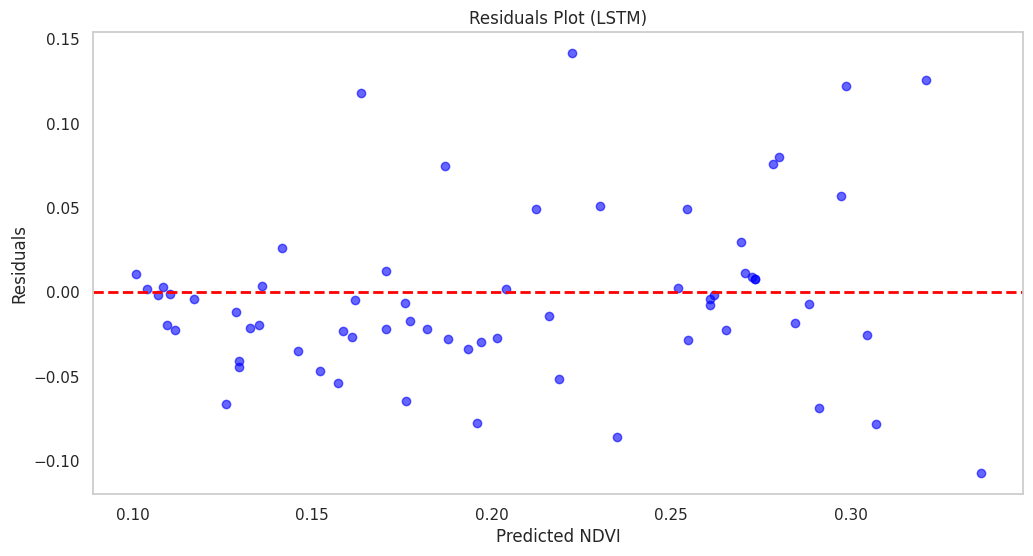

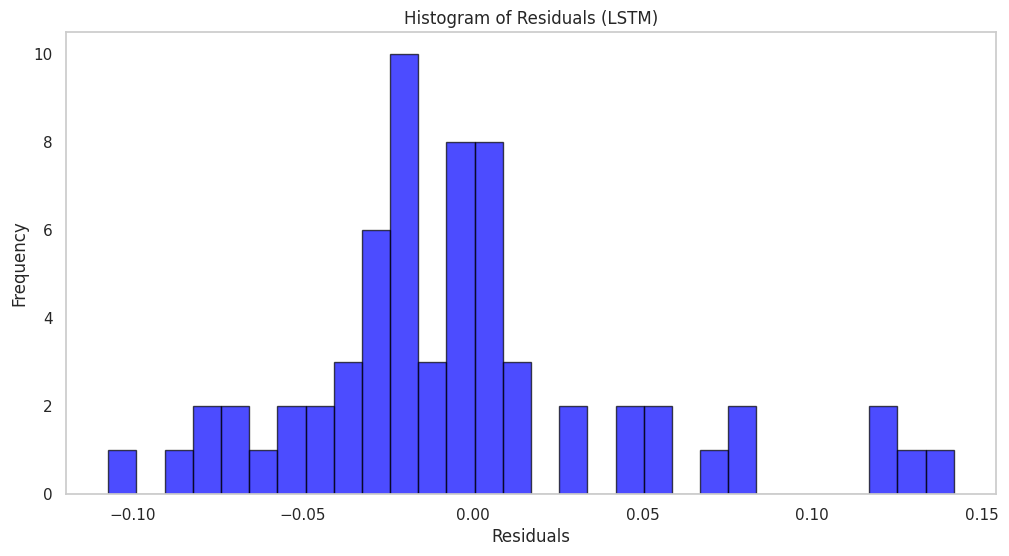

In [42]:
# Cell 2: Visualization of LSTM Model Performance

# Visualization of LSTM Model Performance

# 1. Actual vs. Predicted Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual NDVI', color='blue')
plt.plot(y_test_pred, label='Predicted NDVI', color='orange')
plt.title('Actual vs. Predicted NDVI Values (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('NDVI')
plt.legend()
plt.grid()
plt.show()

# 2. Residuals Plot
plt.figure(figsize=(12, 6))
residuals = y_test - y_test_pred.flatten()  # Flatten the predictions to match the shape
plt.scatter(y_test_pred, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', lw=2)  # Horizontal line at 0
plt.title('Residuals Plot (LSTM)')
plt.xlabel('Predicted NDVI')
plt.ylabel('Residuals')
plt.grid()
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Residuals (LSTM)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()
plt.show()